# Customer Churn Prediction: Telecom Dataset Analysis

## Introduction to the Dataset

### **Dataset Overview**
This notebook explores a comprehensive telecom customer churn dataset containing **1 million records** with **28 features**, designed to simulate real-world customer behavior in the telecommunications industry. The dataset represents synthetic but realistic customer data, perfect for building and testing churn prediction models.

### **Key Statistics**
- **Size:** 1,000,000 rows Ã— 28 columns
- **Target Variable:** `churn` (binary: 1=churned, 0=retained)
- **Churn Rate:** ~23.4% (industry-realistic imbalance)
- **Time Span:** Simulates 5 years of customer tenure
- **Feature Categories:** Demographics, Account, Services, Behavior, Billing

### **Business Context**
Customer churn (attrition) is a critical business problem in telecom, where acquiring new customers costs 5-25Ã— more than retaining existing ones. This dataset enables data scientists to:

1. **Predict** which customers are likely to churn
2. **Understand** key drivers of churn
3. **Develop** targeted retention strategies
4. **Optimize** customer lifetime value

### **Dataset Characteristics**
- **Realistic patterns:** New customers churn more, long-term customers stay
- **Controlled noise:** Missing values (2-5%), mild outliers, realistic correlations
- **ML-ready format:** Clean structure with proper data types
- **Business logic:** Features reflect actual telecom operations


## Load Required Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import VarianceThreshold
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    roc_auc_score,
    roc_curve,
    confusion_matrix,
    ConfusionMatrixDisplay,
    brier_score_loss,
)
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from imblearn.over_sampling import SMOTE

warnings.filterwarnings("ignore")

# Configuration
pd.set_option("display.max_columns", None)
pd.set_option("display.float_format", lambda x: "%.3f" % x)
plt.style.use("seaborn-v0_8-darkgrid")
sns.set_palette("husl")

## Data Loading & Validation

In [2]:
df = pd.read_csv("customer_churn_1M.csv")
df.columns = df.columns.str.lower().str.replace(" ", "_")

if "signup_date" in df.columns:
    df["signup_date"] = pd.to_datetime(df["signup_date"], errors="coerce")

print("Read CSV file successfully.")
print(f"Rows: {df.shape[0]:,} | Columns: {df.shape[1]}")
print("Target present:", "churn" in df.columns)

Read CSV file successfully.
Rows: 1,000,000 | Columns: 32
Target present: True


##  View the Dataset

####  Shape of the dataset

In [3]:
df.shape
print(f"Number of rows: {df.shape[0]}, Number of columns: {df.shape[1]}")

Number of rows: 1000000, Number of columns: 32


#### First View Rows

In [4]:
df.head()

,customer_id,signup_date,age,gender,annual_income,education,marital_status,dependents,tenure,contract,payment_method,paperless_billing,senior_citizen,monthlycharges,totalcharges,num_services,has_phone_service,has_internet_service,has_online_security,has_online_backup,has_device_protection,has_tech_support,has_streaming_tv,has_streaming_movies,customer_satisfaction,num_complaints,num_service_calls,late_payments,avg_monthly_gb,days_since_last_interaction,credit_score,churn
0,CUST0000000001,2022-12-12 12:53:58.199463,43,Female,55085.250,college,married,1,2,two_year,electronic_check,Yes,0,67.200,144.390,1,1,1,0,0,1,1,1,1,9.000,0.000,0,0,109.630,16,NaN,0
1,CUST0000000002,2022-01-13 12:53:58.199973,18,Male,60786.110,master,married,1,22,one_year,bank_transfer,Yes,0,71.540,1602.220,2,0,1,0,1,0,0,0,1,7.000,0.000,3,1,63.250,134,585.000,0
2,CUST0000000003,2023-09-04 12:53:58.199985,38,Female,73184.320,high_school,widowed,0,3,two_year,credit_card,No,0,112.200,328.810,4,1,1,0,0,1,1,1,0,6.000,1.000,1,0,47.770,11,632.000,0
3,CUST0000000004,2022-06-27 12:53:58.199992,44,Male,40923.780,high_school,married,1,6,two_year,bank_transfer,Yes,0,107.490,643.450,3,1,1,0,0,1,1,0,1,5.000,2.000,2,1,50.820,6,569.000,0
4,CUST0000000005,2022-12-08 12:53:58.199999,45,Female,36400.940,bachelor,single,0,9,two_year,credit_card,Yes,0,110.050,648.790,3,0,1,0,0,0,0,0,1,8.000,1.000,1,0,16.740,18,657.000,0


#### Dataset Information

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000000 entries, 0 to 999999
Data columns (total 32 columns):
 #   Column                       Non-Null Count    Dtype         
---  ------                       --------------    -----         
 0   customer_id                  1000000 non-null  object        
 1   signup_date                  1000000 non-null  datetime64[ns]
 2   age                          1000000 non-null  int64         
 3   gender                       1000000 non-null  object        
 4   annual_income                970041 non-null   float64       
 5   education                    1000000 non-null  object        
 6   marital_status               1000000 non-null  object        
 7   dependents                   1000000 non-null  int64         
 8   tenure                       1000000 non-null  int64         
 9   contract                     1000000 non-null  object        
 10  payment_method               1000000 non-null  object        
 11  paperless_bi

#### Statistical Summary

In [6]:
df.describe().T

,count,mean,min,25%,50%,75%,max,std
signup_date,1000000,2023-07-14 13:39:07.319759616,2021-01-13 12:53:58.205311,2022-04-14 12:54:00.628653312,2023-07-14 12:54:09.002999040,2024-10-12 12:54:09.319736320,2026-01-11 12:54:09.480291,NaN
age,1000000.000,44.725,18.000,34.000,44.000,55.000,90.000,14.479
annual_income,970041.000,58788.312,20000.000,32712.560,48954.600,73475.130,250000.000,37137.433
dependents,1000000.000,0.800,0.000,0.000,1.000,1.000,5.000,0.894
tenure,1000000.000,22.382,1.000,6.000,16.000,33.000,72.000,20.073
senior_citizen,1000000.000,0.200,0.000,0.000,0.000,0.000,1.000,0.400
monthlycharges,1000000.000,86.444,20.000,70.490,85.480,100.680,854.957,27.592
totalcharges,1000000.000,1837.321,16.300,484.530,1249.750,2617.660,16252.862,1803.722
num_services,1000000.000,2.564,1.000,1.000,2.000,3.000,6.000,1.412
has_phone_service,1000000.000,0.770,0.000,1.000,1.000,1.000,1.000,0.421


## Views Columns

#### Columns Names

In [7]:
df.columns.tolist()

['customer_id',
 'signup_date',
 'age',
 'gender',
 'annual_income',
 'education',
 'marital_status',
 'dependents',
 'tenure',
 'contract',
 'payment_method',
 'paperless_billing',
 'senior_citizen',
 'monthlycharges',
 'totalcharges',
 'num_services',
 'has_phone_service',
 'has_internet_service',
 'has_online_security',
 'has_online_backup',
 'has_device_protection',
 'has_tech_support',
 'has_streaming_tv',
 'has_streaming_movies',
 'customer_satisfaction',
 'num_complaints',
 'num_service_calls',
 'late_payments',
 'avg_monthly_gb',
 'days_since_last_interaction',
 'credit_score',
 'churn']

#### Categorical Columns

In [8]:
cat_cols= df.select_dtypes(include= ["object", "bool"]).columns.tolist()
print(f"Categorical columns: {cat_cols}")

Categorical columns: ['customer_id', 'gender', 'education', 'marital_status', 'contract', 'payment_method', 'paperless_billing']


#### Numerical Columns

In [9]:
num_cols= df.select_dtypes(include= ["int64", "float64"]).columns.tolist()
print(f"Numverical Columns:{num_cols}")

Numverical Columns:['age', 'annual_income', 'dependents', 'tenure', 'senior_citizen', 'monthlycharges', 'totalcharges', 'num_services', 'has_phone_service', 'has_internet_service', 'has_online_security', 'has_online_backup', 'has_device_protection', 'has_tech_support', 'has_streaming_tv', 'has_streaming_movies', 'customer_satisfaction', 'num_complaints', 'num_service_calls', 'late_payments', 'avg_monthly_gb', 'days_since_last_interaction', 'credit_score', 'churn']


#### Sanity Check

In [10]:
Total_columns= len(cat_cols) + len(num_cols)
print(f"Total Columns: {Total_columns}")

Total Columns: 31


#### Target Columns and Features

In [11]:
# Target column (used later in modeling)
target = "churn"
features_preview = [c for c in df.columns if c not in [target, "customer_id"]]
print(f"Target column: {target}")
print(f"Sample feature columns (preview): {features_preview[:10]} ...")

Target column: churn
Sample feature columns (preview): ['signup_date', 'age', 'gender', 'annual_income', 'education', 'marital_status', 'dependents', 'tenure', 'contract', 'payment_method'] ...


#### Churn Visualisation

## Quick Summary

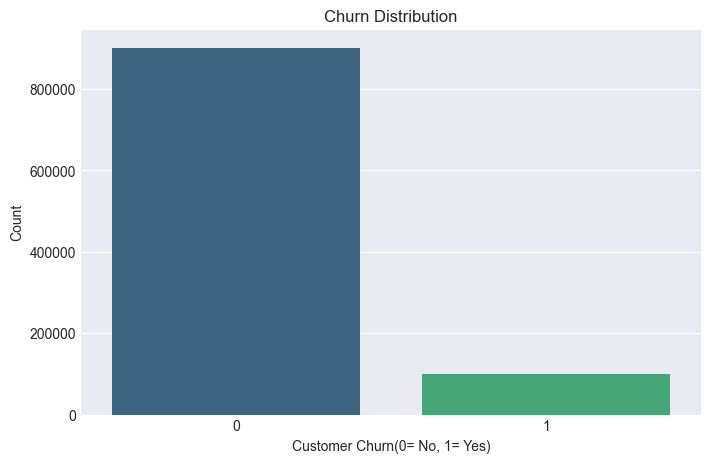

In [12]:
# Churn Visualisation using countplot
plt.figure(figsize=(8,5))
sns.countplot(x= target, data = df , palette="viridis")
plt.title('Churn Distribution')
plt.xlabel("Customer Churn(0= No, 1= Yes)")
plt.ylabel("Count")
plt.show()

In [13]:
# Use the feature preview list already defined in the notebook
features = features_preview

print(f"Total Columns: {Total_columns}")
print(f"Categorical Columns: {cat_cols}")
print(f"Numerical Columns: {num_cols}")
print(f"Target Columns: {target}")
print(f"Feature Columns: {features}")

Total Columns: 31
Categorical Columns: ['customer_id', 'gender', 'education', 'marital_status', 'contract', 'payment_method', 'paperless_billing']
Numerical Columns: ['age', 'annual_income', 'dependents', 'tenure', 'senior_citizen', 'monthlycharges', 'totalcharges', 'num_services', 'has_phone_service', 'has_internet_service', 'has_online_security', 'has_online_backup', 'has_device_protection', 'has_tech_support', 'has_streaming_tv', 'has_streaming_movies', 'customer_satisfaction', 'num_complaints', 'num_service_calls', 'late_payments', 'avg_monthly_gb', 'days_since_last_interaction', 'credit_score', 'churn']
Target Columns: churn
Feature Columns: ['signup_date', 'age', 'gender', 'annual_income', 'education', 'marital_status', 'dependents', 'tenure', 'contract', 'payment_method', 'paperless_billing', 'senior_citizen', 'monthlycharges', 'totalcharges', 'num_services', 'has_phone_service', 'has_internet_service', 'has_online_security', 'has_online_backup', 'has_device_protection', 'has_te

## Missing Values Analysis and Handling

#### Check Missing Values

In [14]:
missing = df.isnull().sum()
missing_sorted = missing[missing > 0].sort_values(ascending=False)
print("Missing Values in columns :")
print(missing_sorted)


Missing Values in columns :
avg_monthly_gb           50012
credit_score             40395
annual_income            29959
num_complaints           29906
customer_satisfaction    19921
dtype: int64


#### Missing value Percentage

In [15]:
# Missing Values Percentage
missing_percent =missing_sorted / len (df) * 100
missing_df = pd.DataFrame({
'Missing_Count': missing_sorted,
'Missing_Percentage': missing_percent
})
missing_df

,Missing_Count,Missing_Percentage
avg_monthly_gb,50012,5.001
credit_score,40395,4.040
annual_income,29959,2.996
num_complaints,29906,2.991
customer_satisfaction,19921,1.992


#### Visualisation of Missing Values

<Figure size 1200x800 with 0 Axes>

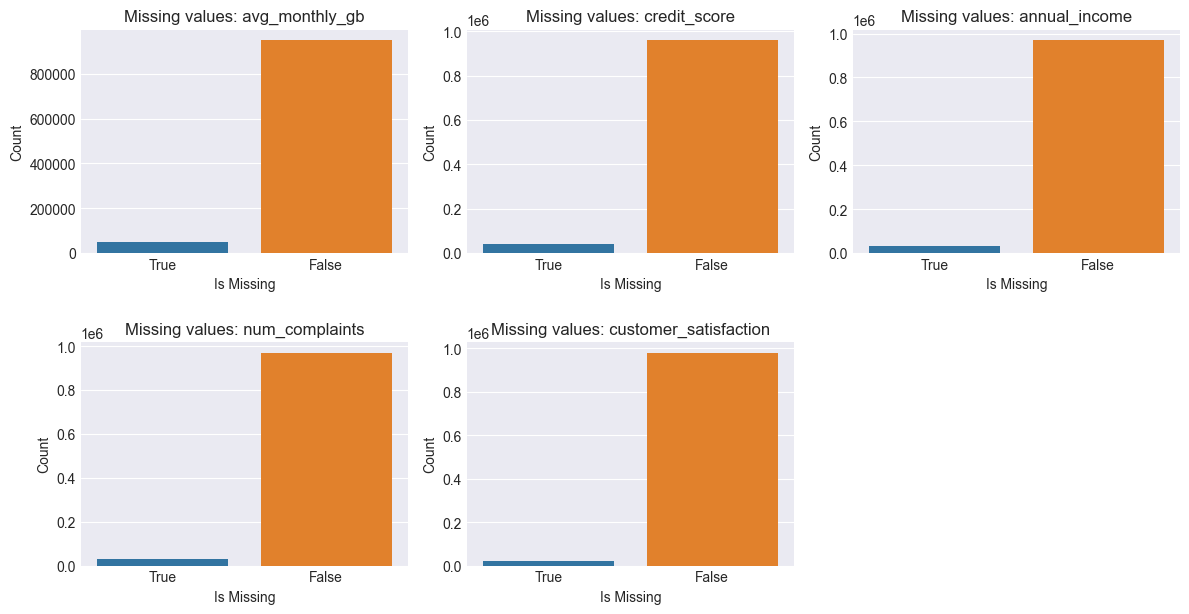

In [16]:
# Visualize missing values for each column on one canvas
missing_columns = missing_sorted.index.tolist()
plt.figure(figsize=(12, 8))
n_cols = 3
n_rows = (len(missing_columns) + n_cols - 1) // n_cols  # ceil division
palette = sns.color_palette(["#1f77b4", "#ff7f0e"])
fig, axes = plt.subplots(n_rows, n_cols, figsize=(4 * n_cols, 3.2 * n_rows))
axes_flat = axes.flatten() if hasattr(axes, "flatten") else [axes]
for ax, col in zip(axes_flat, missing_columns):
    sns.countplot(x=df[col].isnull(), order=[True, False], palette=palette, ax=ax)
    ax.set_xlabel("Is Missing")
    ax.set_ylabel("Count")
    ax.set_title(f"Missing values: {col}")
for ax in axes_flat[len(missing_columns):]:
    ax.axis("off")
plt.tight_layout()
plt.show()

#### 6.4 Handling Missing Vales
   <h5>  General Rules (Industry Standard) </h5>
if
   <ul> Numberical(skewed) missing values then replace with Median of column </ul>
   <ul> Numerical(normal) missing values then replace with Mean of column</ul>
   <ul> Categorical missing values then replace with Mean of column</ul>
 elif
   <ul> High missing (>40%) then Consider to drop</ul>
 else
    <ul>leave as Same </ul>


In [17]:
# Do NOT impute here to avoid leakage; handled in pipeline after split.
missing_num = df.select_dtypes(include=["number"]).isnull().sum()
missing_cat = df.select_dtypes(include=["object", "category", "bool"]).isnull().sum()

print("Numerical missing (top 10):")
display(missing_num[missing_num > 0].sort_values(ascending=False).head(10))
print("Categorical missing (top 10):")
display(missing_cat[missing_cat > 0].sort_values(ascending=False).head(10))

Numerical missing (top 10):


avg_monthly_gb           50012
credit_score             40395
annual_income            29959
num_complaints           29906
customer_satisfaction    19921
dtype: int64

Categorical missing (top 10):


Series([], dtype: int64)

#### Verify Missing Values are Handled

In [18]:
# Verify missing values are still present (expected before preprocessing)
print(f"Total missing values in raw data: {df.isnull().sum().sum():,}")

Total missing values in raw data: 170,193


#### Handle Duplicates

In [19]:
df.duplicated().sum()


np.int64(0)

## Univairate Analysis(Single Virable)

### Numerical Variables( Histograms + KDE)
 We want to understand:
    <li>Distribution shape (normal / skewed) </li>
    <li>Presence of outliers </li>
    <li> Scale differences </li>

What to Observe  

    <li>Right-skewed â†’ log transform later </li>
    <li>Long tails â†’ outliers</li>

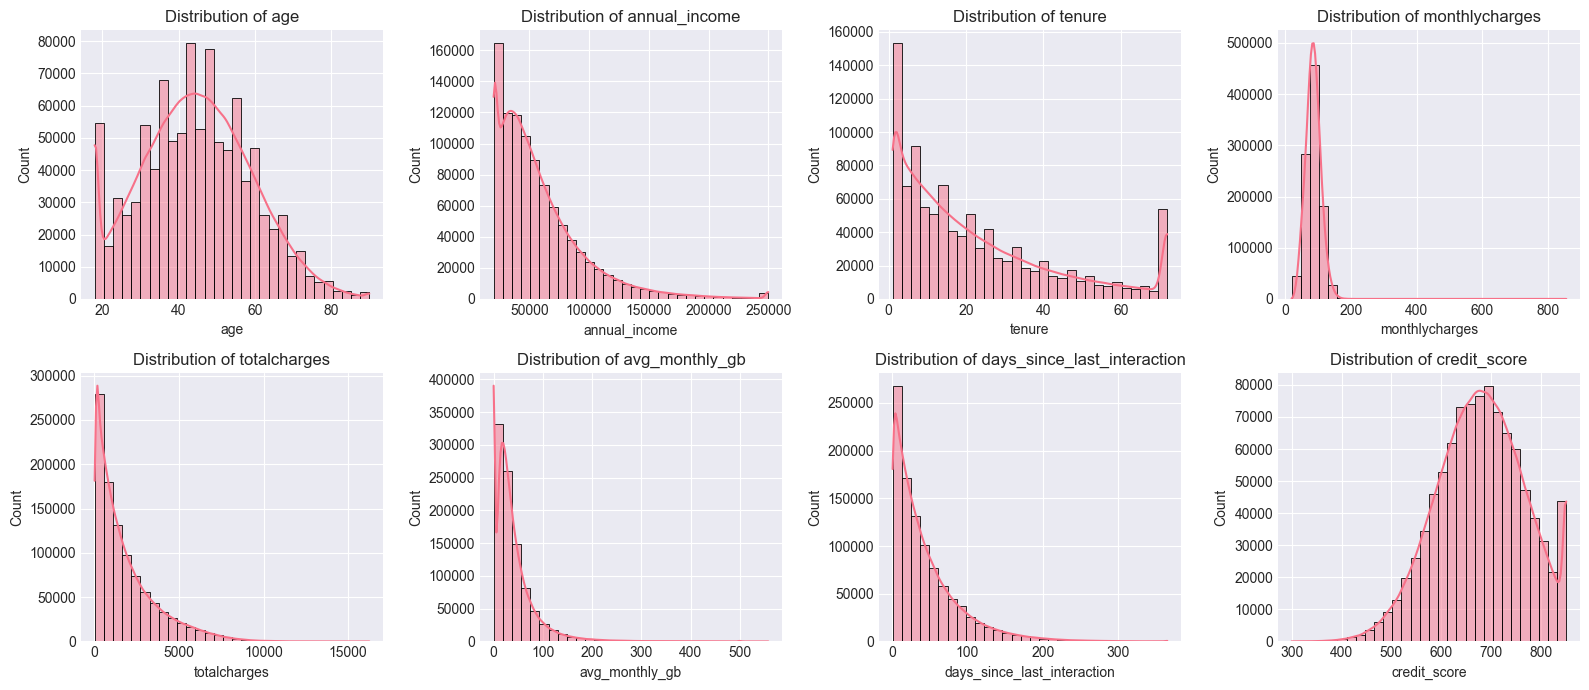

In [20]:
# Histograms + KDE for numerical features
num_features = ['age', 'annual_income','tenure', 'monthlycharges', 'totalcharges', 'avg_monthly_gb', 'days_since_last_interaction', 'credit_score', ]
n_cols = 4
n_rows = int(np.ceil(len(num_features) / n_cols))
plt.figure(figsize=(4 * n_cols, 3.5 * n_rows))

for i, col in enumerate(num_features, 1):
    plt.subplot(n_rows, n_cols, i)
    sns.histplot(df[col], kde=True, bins=30, line_kws={"color": "blue"})
    plt.title(f"Distribution of {col}")
    plt.xlabel(col)
    plt.ylabel("Count")

plt.tight_layout()
plt.show()

#### Boxplot(Outlier Detection)
 We want to understand
    <li>Points outside whiskers â†’ outliers </li>
    <li>Extremely wide ranges â†’ scaling required</li>

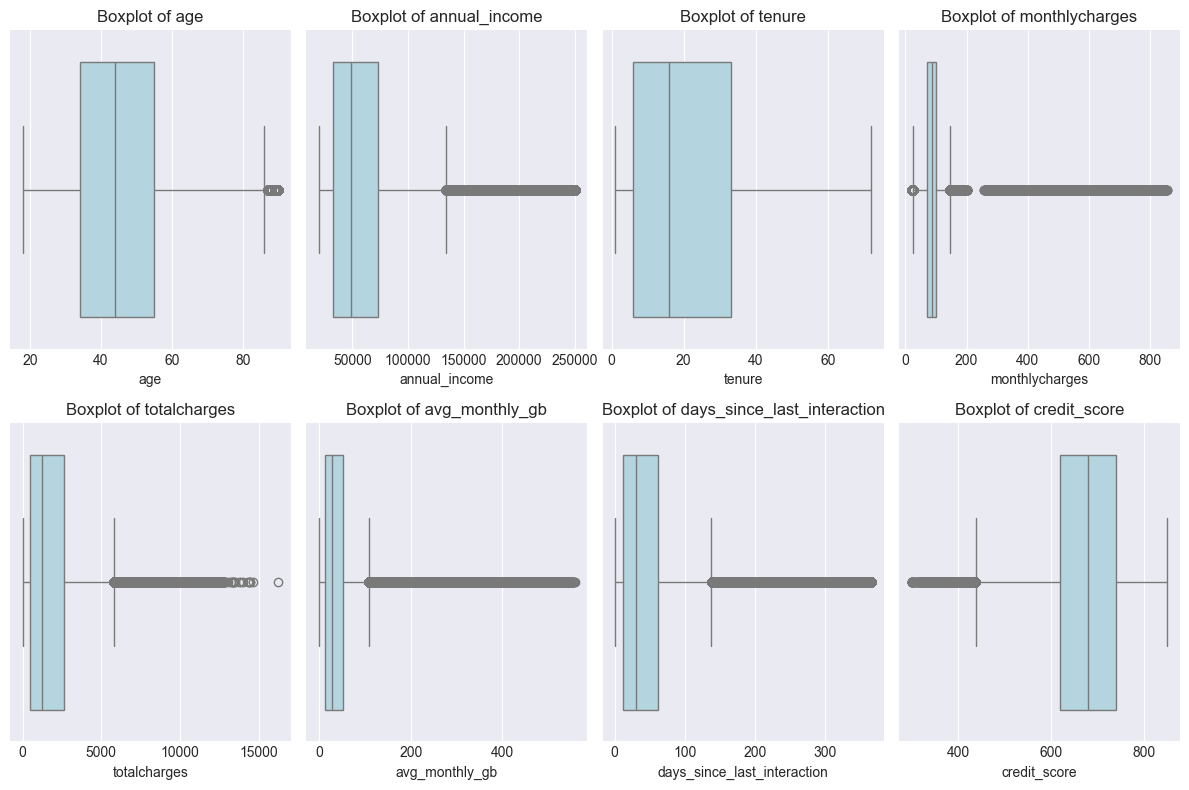

In [21]:
# Boxplots for Numerical Features
n_cols = 4
n_rows = int(np.ceil(len(num_features) / n_cols))
fig_box, axes_box = plt.subplots(n_rows, n_cols, figsize=(3 * n_cols, 4 * n_rows))
axes_box_flat = axes_box.flatten()

for ax_box, col in zip(axes_box_flat, num_features):
    sns.boxplot(x=df[col], ax=ax_box, color="lightblue")
    ax_box.set_title(f"Boxplot of {col}")
    ax_box.set_xlabel(col)

for ax_box in axes_box_flat[len(num_features):]:
    ax_box.axis("off")

plt.tight_layout()
plt.show()


#### Categorical Fearute(Countplot)
   <h4> why this matter</h4>
    We check:
    <li>Class imbalance</li>
    <li>Rare categories</li>
    <li>Dominant Categories(risk of bias)</li>

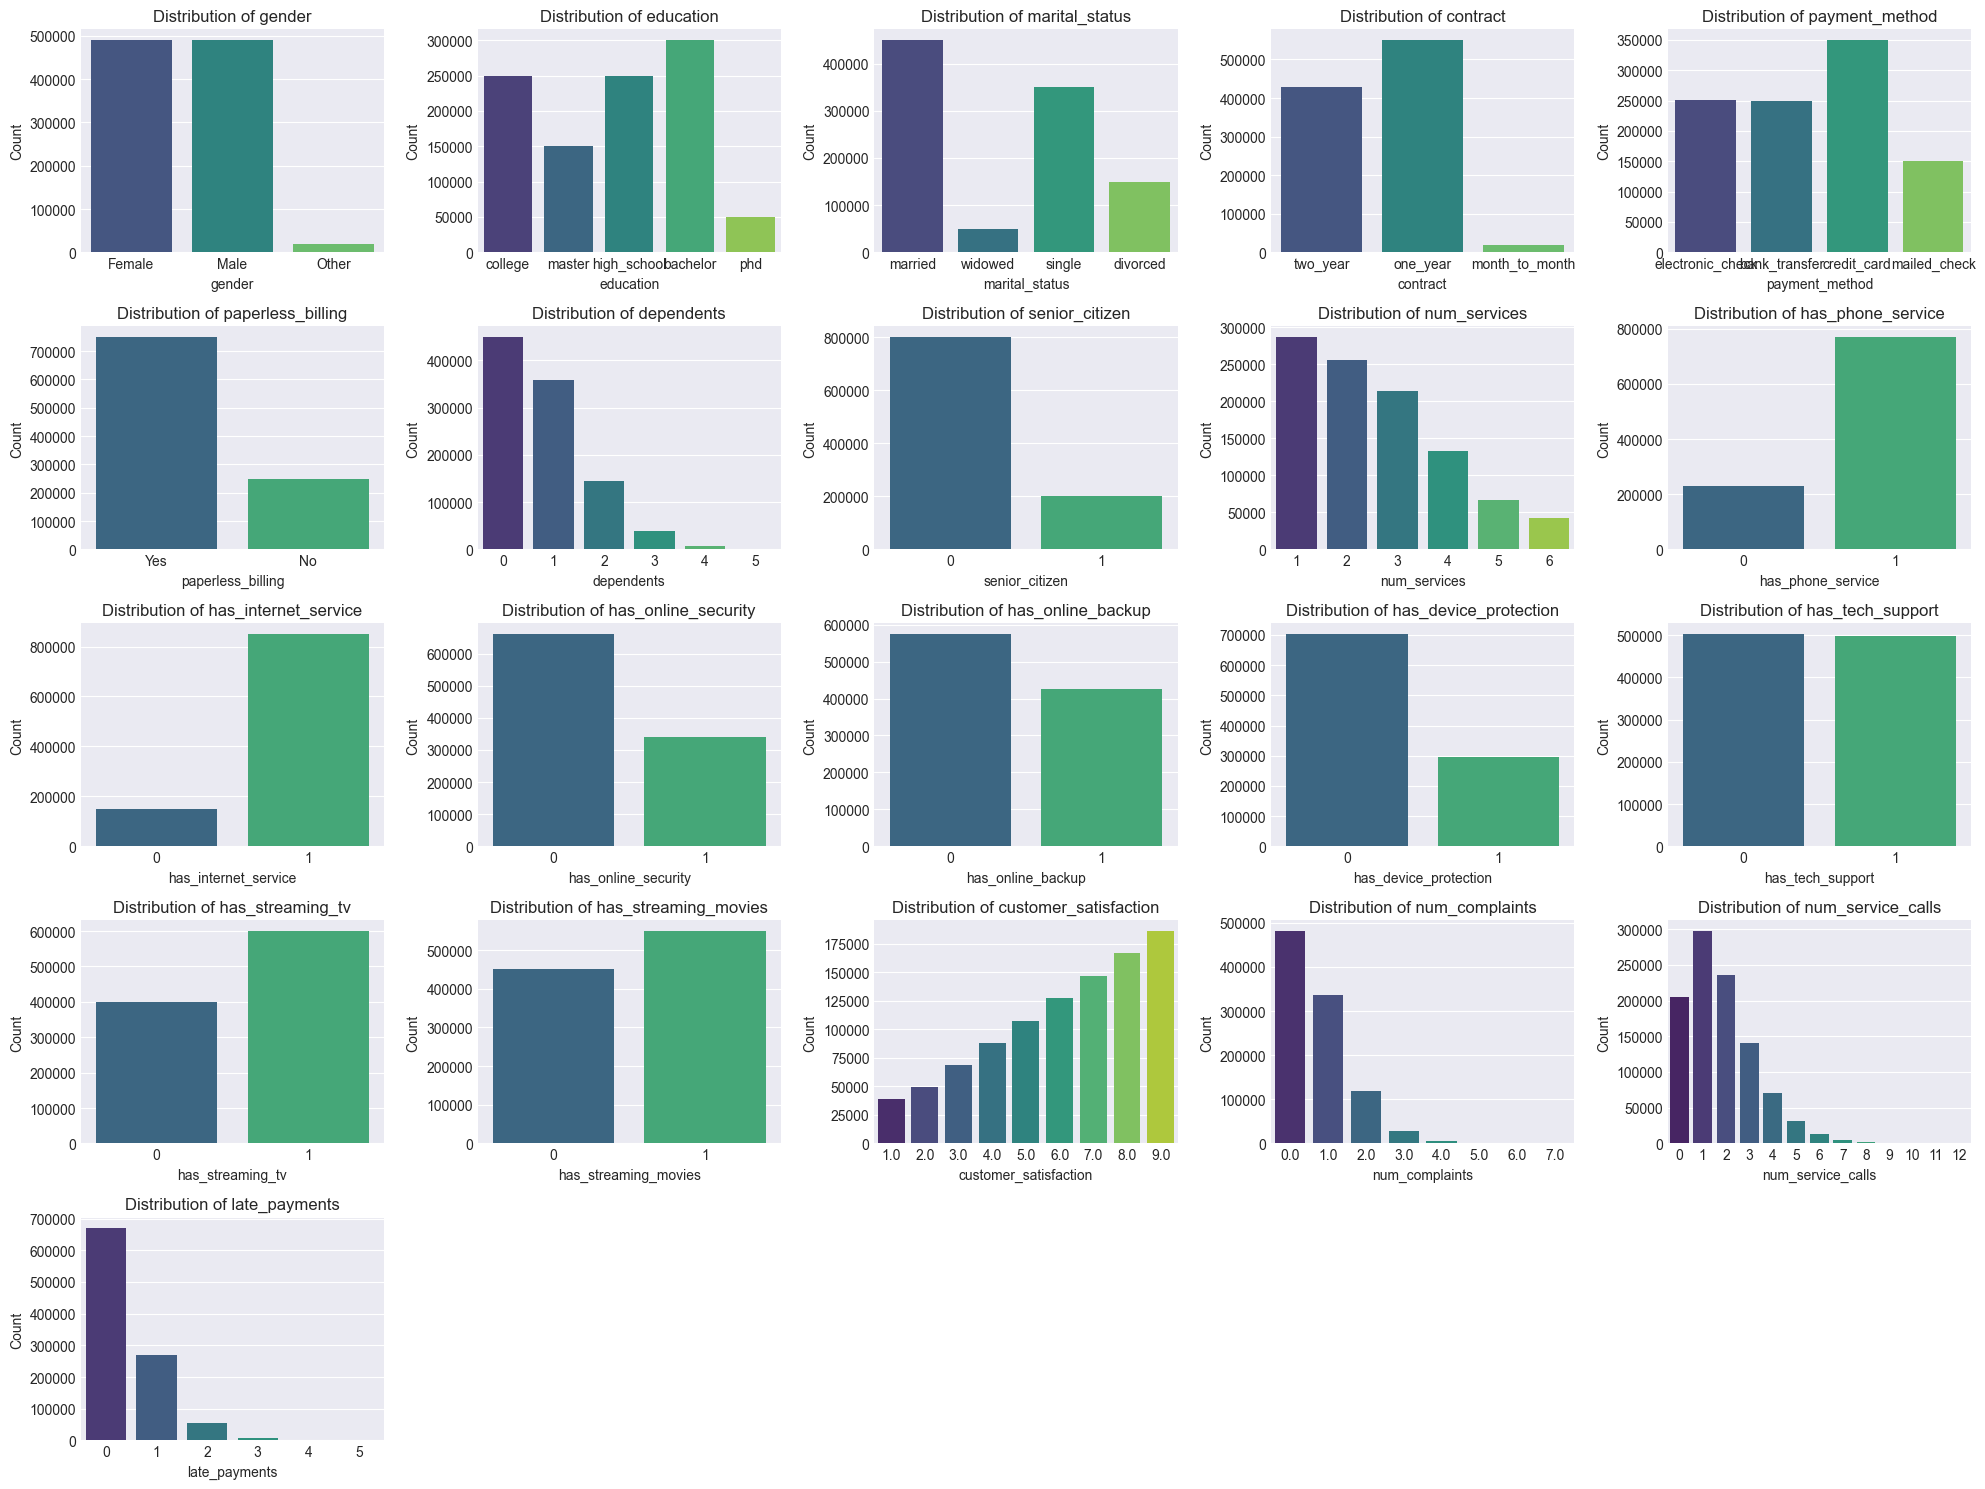

In [22]:
# Distribution plots for Categorical Features
cat_features = ['gender', 'education', 'marital_status', 'contract', 'payment_method', 'paperless_billing', 'dependents', 'senior_citizen', 'num_services', 'has_phone_service', 'has_internet_service', 'has_online_security', 'has_online_backup', 'has_device_protection', 'has_tech_support', 'has_streaming_tv', 'has_streaming_movies', 'customer_satisfaction', 'num_complaints', 'num_service_calls', 'late_payments']

n_cols = 5
n_rows = int(np.ceil(len(cat_features) / n_cols))

plt.figure(figsize=(4 * n_cols, 3 * n_rows))
for i, col in enumerate(cat_features, 1):
	plt.subplot(n_rows, n_cols, i)
	sns.countplot(x=df[col], data=df, palette="viridis")
	plt.title(f"Distribution of {col}")
	plt.xlabel(col)
	plt.ylabel("Count")

plt.tight_layout()
plt.show()


#### Category Percentage Distribution
What to Look For
 <li>Categories < 1% â†’ consider grouping as "Other" </li>
    <li>Binary columns â†’ good candidates for label encoding</li>
    <li>High-cardinality columns â†’ target / frequency encoding later</li>

In [23]:
# Category feature percentage distribution
for col in cat_features:
    print(f"\n{col} Value Distribution(%):")
    print(round(df[col].value_counts(normalize=True) * 100, 2))


gender Value Distribution(%):
gender
Male     49.020
Female   48.960
Other     2.020
Name: proportion, dtype: float64

education Value Distribution(%):
education
bachelor      30.030
college       24.960
high_school   24.930
master        15.050
phd            5.030
Name: proportion, dtype: float64

marital_status Value Distribution(%):
marital_status
married    45.010
single     35.080
divorced   14.900
widowed     5.010
Name: proportion, dtype: float64

contract Value Distribution(%):
contract
one_year         55.050
two_year         42.950
month_to_month    2.000
Name: proportion, dtype: float64

payment_method Value Distribution(%):
payment_method
credit_card        34.970
electronic_check   25.030
bank_transfer      24.990
mailed_check       15.000
Name: proportion, dtype: float64

paperless_billing Value Distribution(%):
paperless_billing
Yes   74.990
No    25.010
Name: proportion, dtype: float64

dependents Value Distribution(%):
dependents
0   44.940
1   35.940
2   14.380
3   

## Bivariate Analysis

#### Numerical Vs Churn(Statistics)

In [24]:
available_num_features = [col for col in num_features if col in df.columns]
missing_in_df = set(num_features) - set(available_num_features)
if missing_in_df:
	print(f"Skipped missing columns: {missing_in_df}")

df.groupby("churn")[available_num_features].mean()

,age,annual_income,tenure,monthlycharges,totalcharges,avg_monthly_gb,days_since_last_interaction,credit_score
churn,,,,,,,,
0,44.723,58782.574,22.467,86.571,1847.200,39.185,44.488,678.573
1,44.736,58840.399,21.613,85.292,1747.645,38.283,44.547,678.462


#### Visualisation of Numerical Features

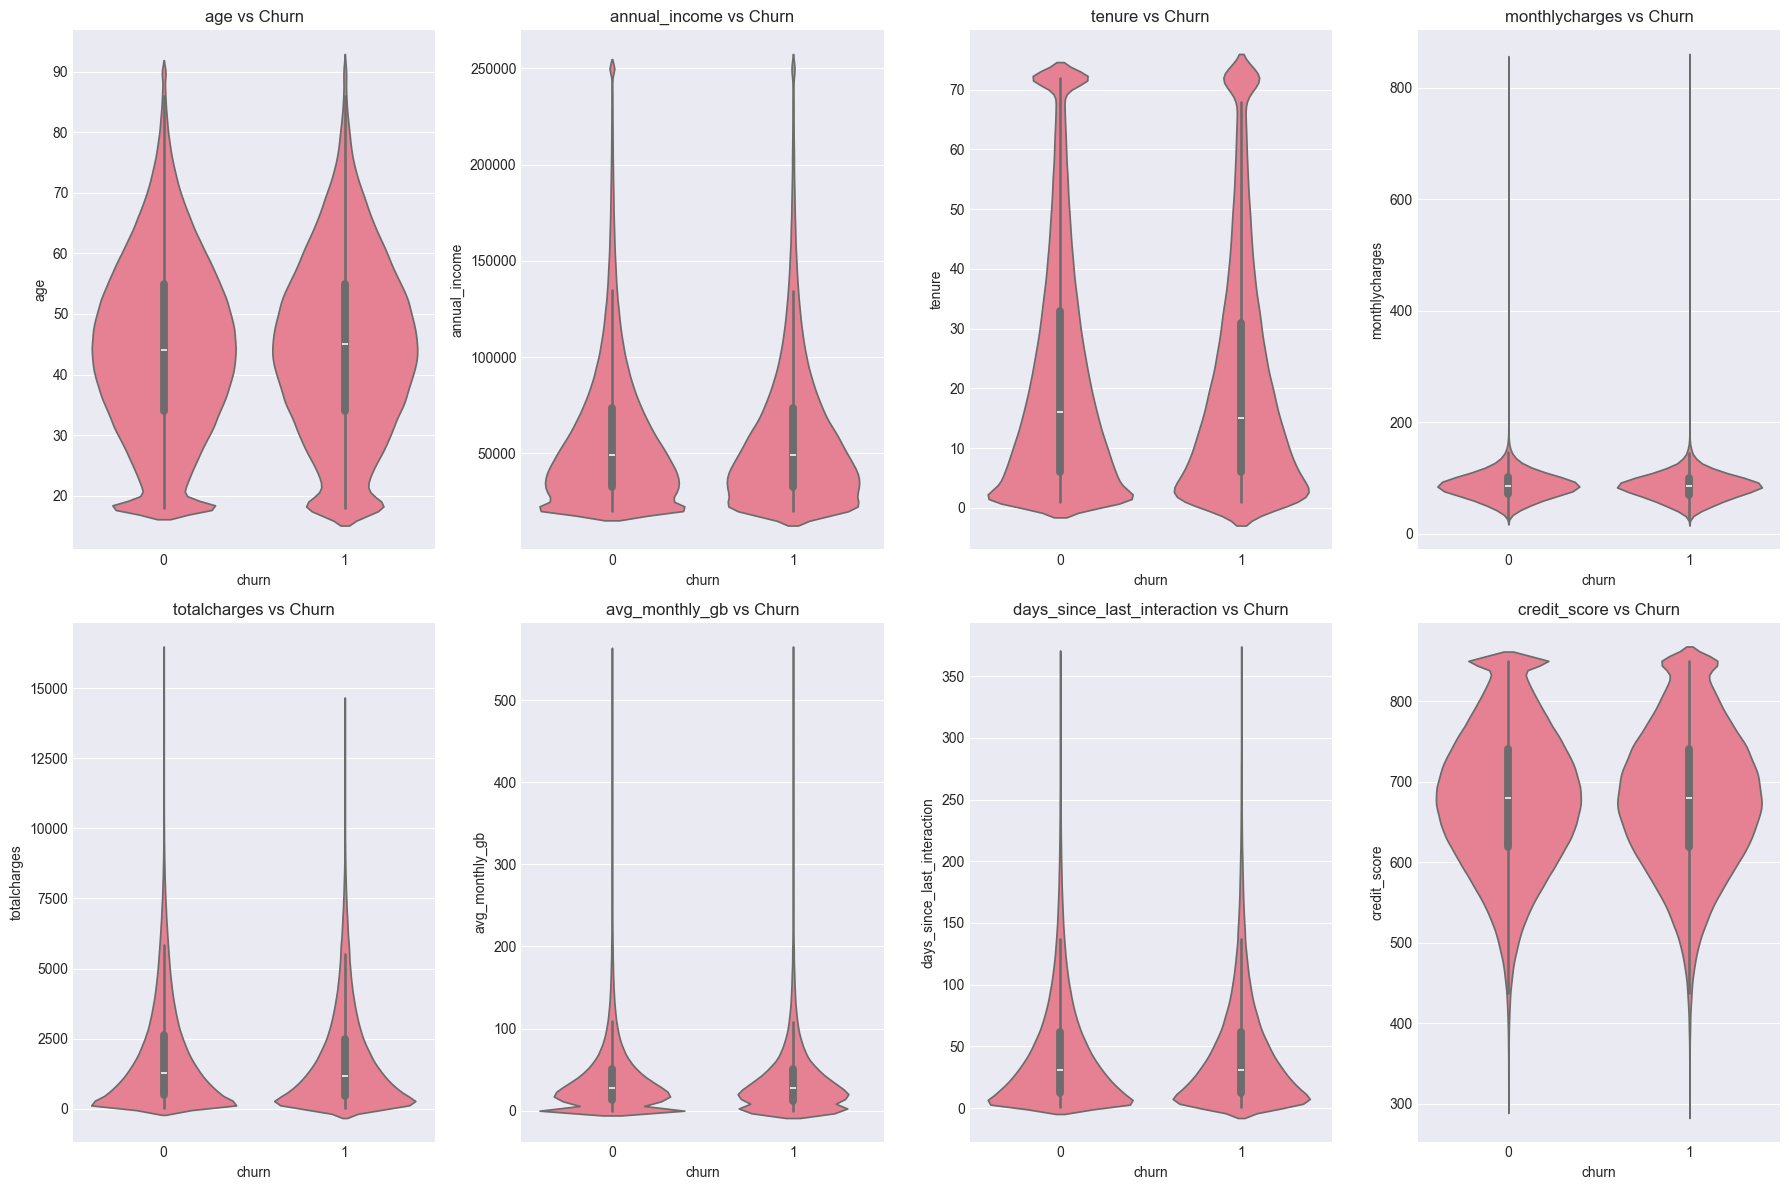

In [25]:
plt.figure(figsize=(18, 12))

n_cols = 4
n_rows = int(np.ceil(len(available_num_features) / n_cols))

for i, col in enumerate(available_num_features, 1):
    plt.subplot(n_rows, n_cols, i)
    sns.violinplot(x="churn", y=col, data=df)
    plt.title(f"{col} vs Churn")

plt.tight_layout()
plt.show()


**Numerical vs Churn Rate Insights**

- **Monthly & Total Charges:** Higher monthly charges correlate with higher churn; longer-tenure customers with high total charges churn less.
- **Tenure:** Short-tenure customers churn more; churn risk steadily declines with longer tenure.
- **Charges per Tenure / High Charge Early:** High early charges increase churn; sustained high charges over long tenure reduce churn risk.
- **Customer Satisfaction:** Lower satisfaction strongly increases churn likelihood.
- **Complaints & Service Calls:** More complaints or service calls align with higher churn.
- **Late Payments:** Frequent late payments signal elevated churn risk.
- **Usage & Engagement:** Lower average monthly GB and fewer interactions indicate disengagement and higher churn.
- **Credit Score:** Lower credit scores show a modest positive association with churn.

#### Catergorical vs Churn

In [26]:
for col in cat_features:
    churn_rate = df.groupby(col)["churn"].mean().sort_values(ascending=False)
    print(f"\nChurn Rate by {col}")
    print(churn_rate)


Churn Rate by gender
gender
Male     0.099
Female   0.099
Other    0.098
Name: churn, dtype: float64

Churn Rate by education
education
master        0.100
bachelor      0.100
high_school   0.099
phd           0.099
college       0.099
Name: churn, dtype: float64

Churn Rate by marital_status
marital_status
divorced   0.100
married    0.100
single     0.099
widowed    0.097
Name: churn, dtype: float64

Churn Rate by contract
contract
month_to_month   0.265
one_year         0.127
two_year         0.057
Name: churn, dtype: float64

Churn Rate by payment_method
payment_method
electronic_check   0.099
bank_transfer      0.099
credit_card        0.099
mailed_check       0.099
Name: churn, dtype: float64

Churn Rate by paperless_billing
paperless_billing
No    0.100
Yes   0.099
Name: churn, dtype: float64

Churn Rate by dependents
dependents
5   0.111
1   0.099
0   0.099
4   0.099
2   0.099
3   0.099
Name: churn, dtype: float64

Churn Rate by senior_citizen
senior_citizen
1   0.099
0   0.09

#### Visualisation for  Categorical vs Churn

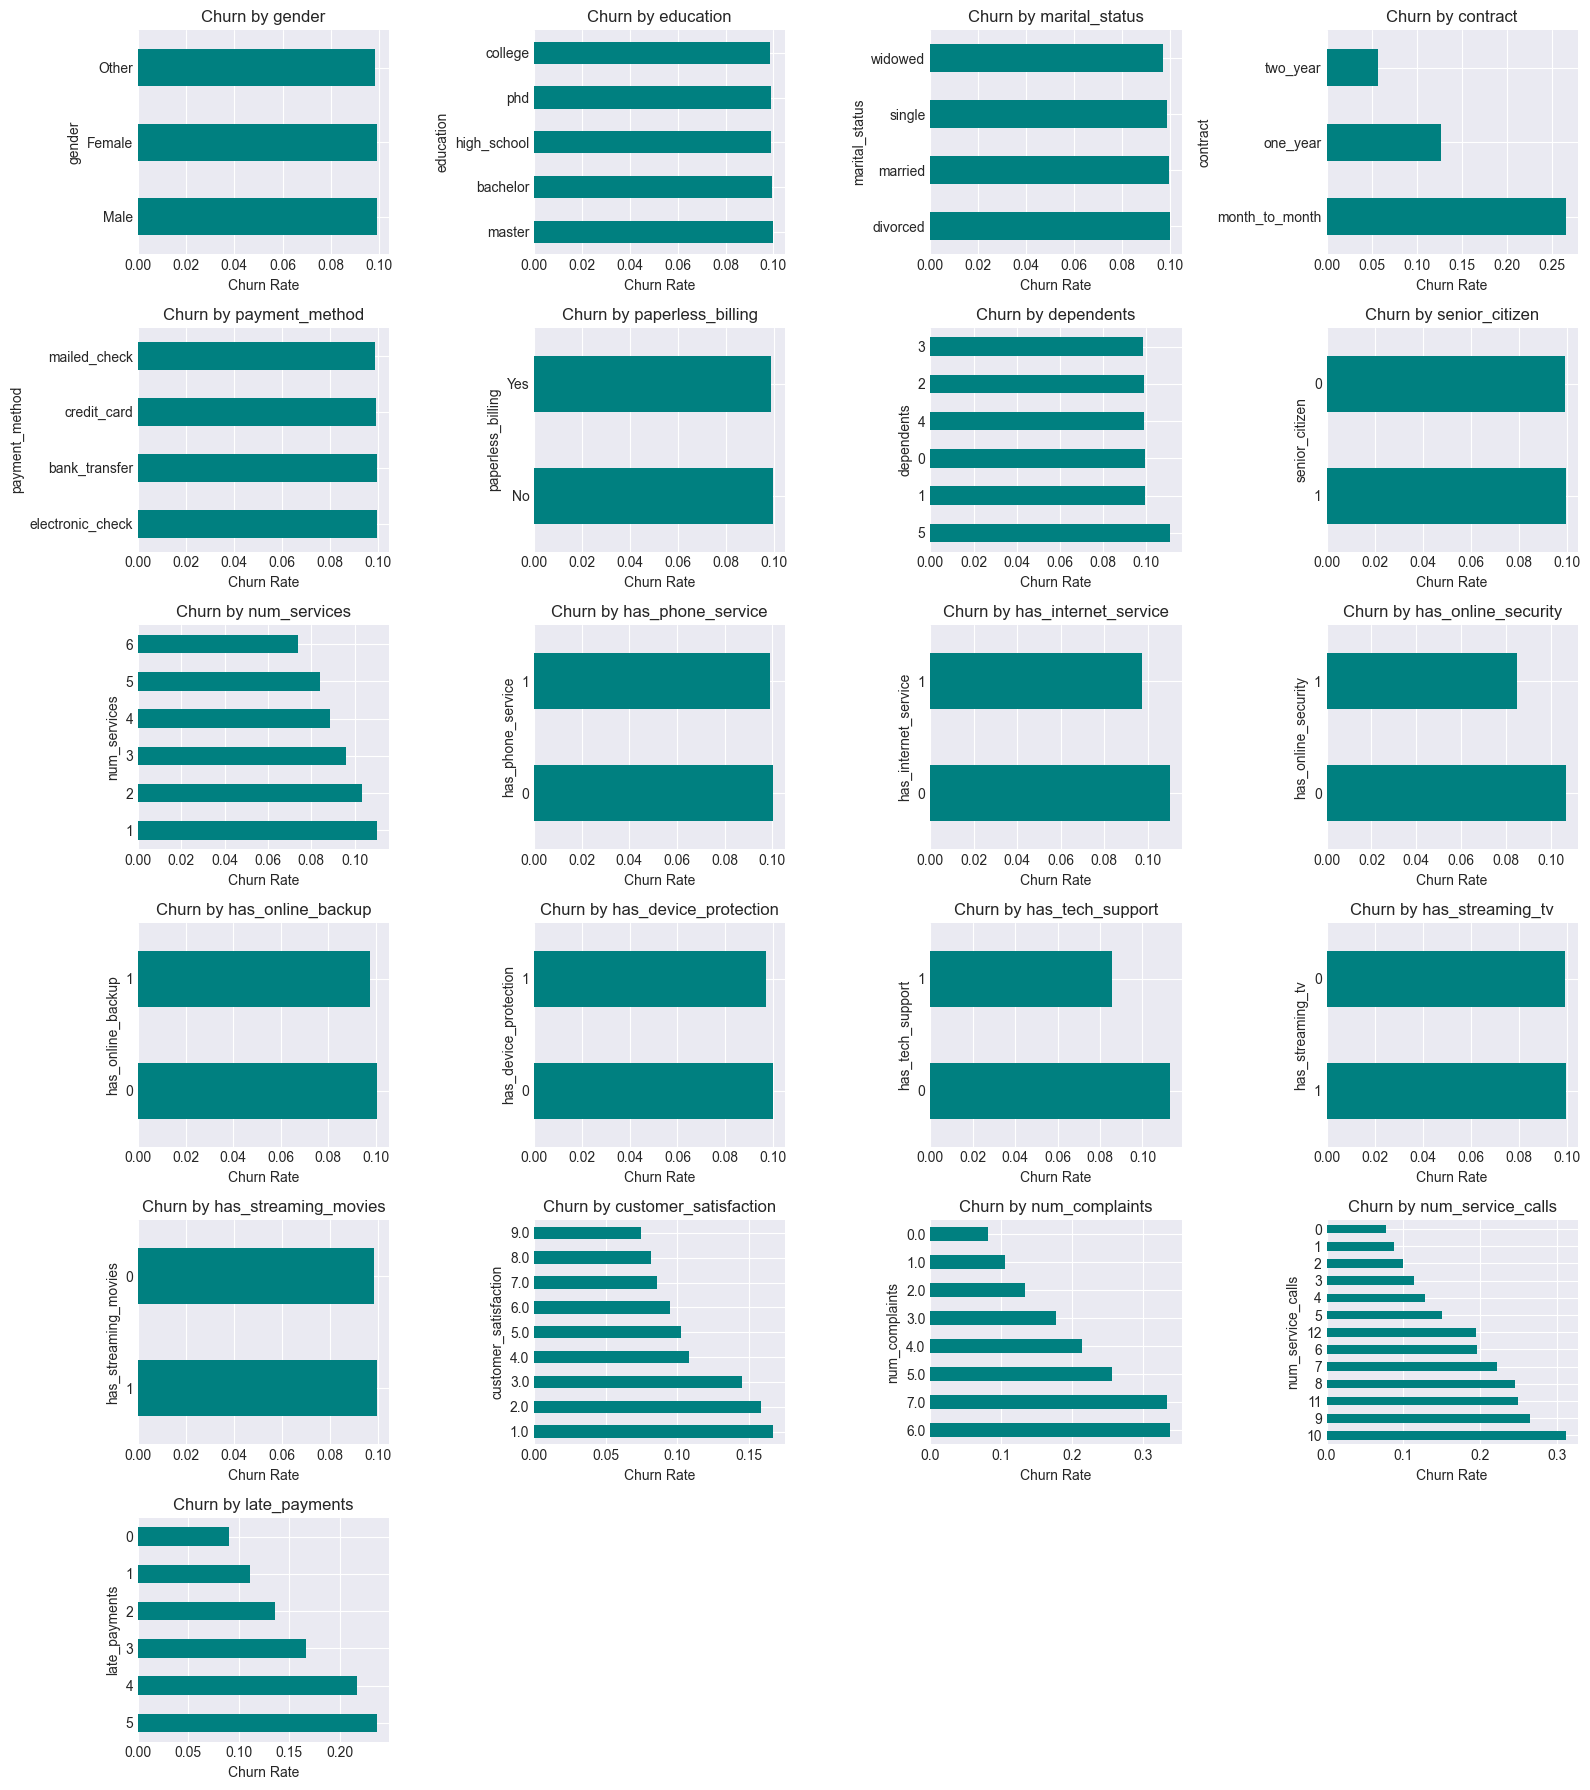

In [27]:
### Categorical vs Churn
cat_n_cols = 4
cat_n_rows = (len(cat_features) + cat_n_cols - 1) // cat_n_cols

fig, axes_cat = plt.subplots(cat_n_rows, cat_n_cols, figsize=(4 * cat_n_cols, 3 * cat_n_rows))
axes_cat_flat = axes_cat.flatten() if hasattr(axes_cat, "flatten") else [axes_cat]

for i, col in enumerate(cat_features):
    ax_cat = axes_cat_flat[i]
    df.groupby(col)["churn"].mean().sort_values(ascending=False).plot(kind="barh", ax=ax_cat, color="teal")
    ax_cat.set_title(f"Churn by {col}")
    ax_cat.set_xlabel("Churn Rate")

for ax_cat in axes_cat_flat[len(cat_features):]:
    ax_cat.axis("off")

plt.tight_layout()
plt.show()


Categorical vs Churn Rate highlights:
- Contract: month-to-month customers churn more; two-year contracts churn less.
- Payment Method: electronic check users churn more; bank transfer/credit card users churn less.
- Security/Support: customers without online security or tech support churn more; those with these services churn less.
- Paperless Billing: slight uptick in churn among paperless users compared to non-paperless.


## Step  Multivirate Analysis

#### Tenure * Monthlycharges * churn

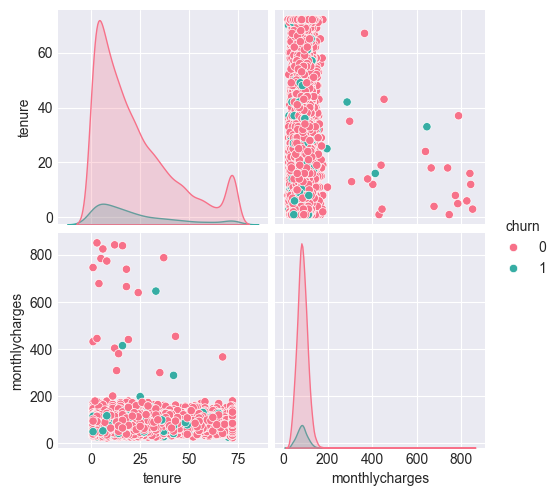

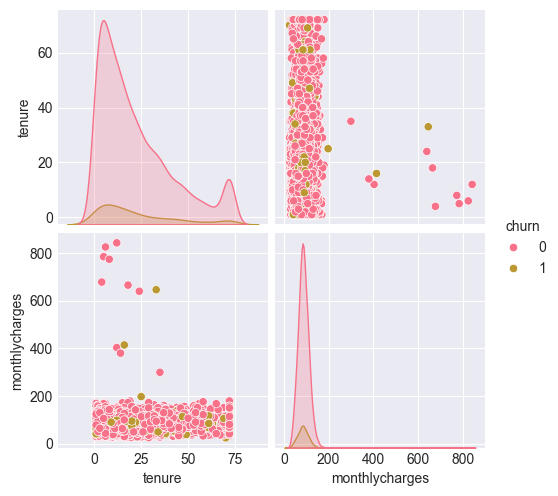

In [28]:
cols = ["tenure", "monthlycharges"]
sample_df = df.sample(20_000, random_state=42)
sns.pairplot(sample_df, vars=cols, hue=target, palette="husl")

sns.pairplot(
    df.sample(10_000, random_state=42),
    vars=cols[:2],
    hue=target,
    diag_kind='kde'
)

##### Highlight points: Tenure × Monthly Charges × Churn

- **Early-tenure risk:** Customers in their first ~12 months show the highest churn, especially with mid-to-high monthly charges.  
- **Price sensitivity:** As monthly charges increase, churn probability rises—most visible among short-tenure customers.  

### Tenure * Contract_code * Churn

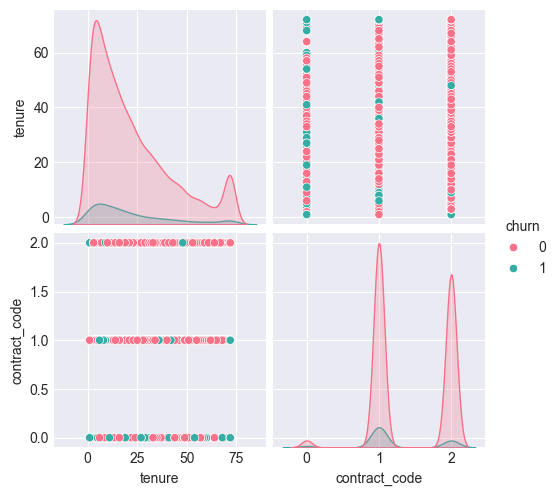

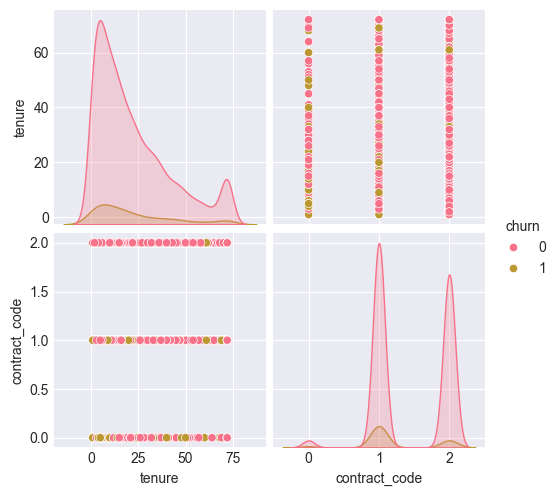

In [29]:
# Encode categorical "contract" to numeric for pairplot
sample_df = df.sample(20_000, random_state=42).copy()
sample_df["contract_code"] = pd.Categorical(sample_df["contract"]).codes
cols = ["tenure", "contract_code"]
sns.pairplot(sample_df, vars=cols, hue=target, palette="husl")

sample_df_small = df.sample(10_000, random_state=42).copy()
sample_df_small["contract_code"] = pd.Categorical(sample_df_small["contract"]).codes
sns.pairplot(
    sample_df_small,
    vars=cols,
    hue=target,
    diag_kind="kde"
)

Key insights from Tenure × Contract × Churn:
- **Highest churn:** Month-to-month customers with short tenure drive most churn; risk decreases sharply after ~12 months.  
- **Moderate churn:** One-year contracts reduce churn versus month-to-month at comparable tenure.  
- **Lowest churn:** Two-year contracts show the lowest churn, especially beyond the first year.
- Month-to-month customers with short tenure drive most churn; risk decreases sharply after ~12 months.
- One-year contracts reduce churn versus month-to-month at comparable tenure.
- Two-year contracts show the lowest churn, especially beyond the first year.

#### Number of Complaints * Number of Service Calls * Churn

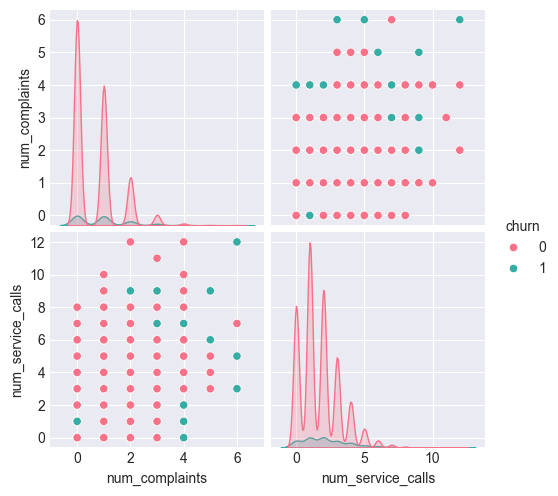

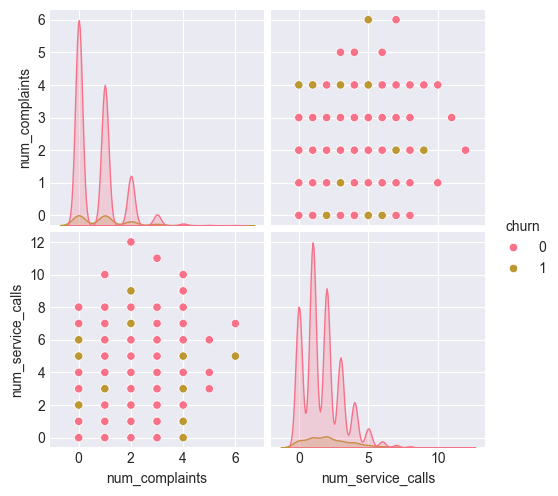

In [30]:
# Pairplot for complaint- and service-related activity vs churn
cols = ["num_complaints", "num_service_calls"]

sample_df = df.sample(20_000, random_state=42).copy()
sns.pairplot(sample_df, vars=cols, hue=target, palette="husl")

sample_df_small = df.sample(10_000, random_state=42).copy()
sns.pairplot(
    sample_df_small,
    vars=cols,
    hue=target,
    diag_kind="kde"
)

- **Churn spikes with activity:** Customers showing multiple complaints and frequent service calls have the highest churn likelihood.  
- **Low-touch, low-risk:** Few complaints and few service calls correspond to the lowest churn rates.  
- **Compounding effect:** Even with moderate service calls, churn increases sharply once complaints accumulate.  

#### Monthly Charges * Customer Satisfaction * Churn

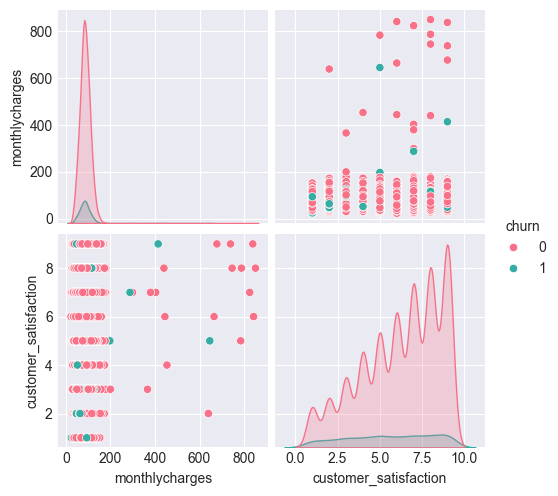

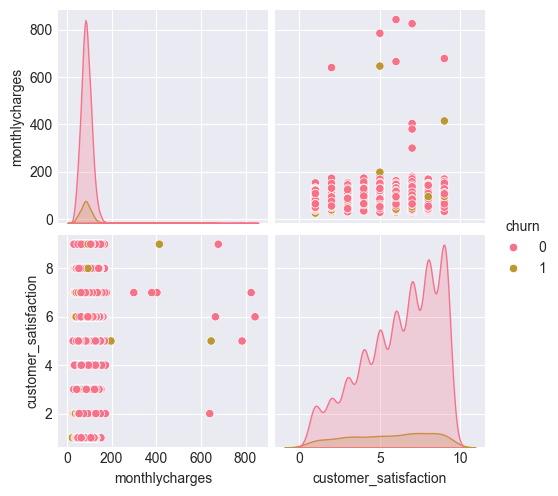

In [31]:
# Pairplot for complaint- and service-related activity vs churn
cols = ["monthlycharges", "customer_satisfaction"]

sample_df = df.sample(20_000, random_state=42).copy()
sns.pairplot(sample_df, vars=cols, hue=target, palette="husl")

sample_df_small = df.sample(10_000, random_state=42).copy()
sns.pairplot(
    sample_df_small,
    vars=cols,
    hue=target,
    diag_kind="kde"
)

### Key takeaways: Monthly Charges × Customer Satisfaction × Churn
- **Highest churn:** High monthly charges + low satisfaction.  
- **Mixed churn:** Mid charges + mid satisfaction—experience/support drives outcomes.  
- **Lowest churn:** Low charges + high satisfaction show strong retention.  
- **Action:** Lift satisfaction for high-charge customers to cut churn.

## Grouping Data (Aggregation Analysis)
These aggregations highlight which customer segments drive churn and how revenue differs across those segments.

In [32]:
df_agg = df.copy()
if "tenure" in df_agg.columns:
    df_agg["tenure_group"] = pd.cut(
        df_agg["tenure"],
        bins=[0, 12, 24, 36, 48, 60, np.inf],
        labels=["0-12", "13-24", "25-36", "37-48", "49-60", "61+"],
)

def agg_table(group_col):
    return (
        df_agg.groupby(group_col)
        .agg(
            churn_rate=("churn", "mean"),
            customer_count=("churn", "size"),
            avg_monthly_charges=("monthlycharges", "mean"),
        )
        .sort_values("churn_rate", ascending=False)
    )

for col in ["contract", "tenure_group", "payment_method"]:
    if col in df_agg.columns:
        print(f"\nChurn by {col}")
        display(agg_table(col))


Churn by contract


,churn_rate,customer_count,avg_monthly_charges
contract,,,
month_to_month,0.265,19992,86.284
one_year,0.127,550468,86.497
two_year,0.057,429540,86.383



Churn by tenure_group


,churn_rate,customer_count,avg_monthly_charges
tenure_group,,,
0-12,0.103,418055,86.410
13-24,0.100,228860,86.520
25-36,0.098,139525,86.450
37-48,0.094,83532,86.534
61+,0.092,78815,86.250
49-60,0.092,51213,86.513



Churn by payment_method


,churn_rate,customer_count,avg_monthly_charges
payment_method,,,
electronic_check,0.099,250346,86.435
bank_transfer,0.099,249910,86.396
credit_card,0.099,349706,86.461
mailed_check,0.099,150038,86.498


These summaries show which contract, tenure bands, and payment methods have the highest churn rates, helping prioritize retention campaigns where impact is largest.

## ANOVA (Numerical vs Categorical)
ANOVA tests whether the mean of a numeric feature differs significantly between churned and retained customers.

In [33]:
from scipy.stats import f_oneway

anova_features = ["tenure", "monthlycharges", "totalcharges"]
anova_features = [f for f in anova_features if f in df.columns]

for feature in anova_features:
    group0 = df.loc[df["churn"] == 0, feature].dropna()
    group1 = df.loc[df["churn"] == 1, feature].dropna()
    f_stat, p_val = f_oneway(group0, group1)
    print(f"{feature}: F = {f_stat:.3f}, p = {p_val:.6f}")

tenure: F = 161.537, p = 0.000000
monthlycharges: F = 191.819, p = 0.000000
totalcharges: F = 272.363, p = 0.000000


If the p-value is below 0.05, the feature shows statistically significant differences between churned and retained groups, indicating it is likely useful for prediction.

## Correlation Analysis
We examine linear relationships between numeric features and churn to spot strong drivers and potential redundancy.

,age,annual_income,dependents,tenure,senior_citizen,monthlycharges,totalcharges,num_services,has_phone_service,has_internet_service,has_online_security,has_online_backup,has_device_protection,has_tech_support,has_streaming_tv,has_streaming_movies,customer_satisfaction,num_complaints,num_service_calls,late_payments,avg_monthly_gb,days_since_last_interaction,credit_score,churn
age,1.000,0.001,-0.000,0.002,0.000,-0.001,0.001,-0.001,0.002,0.000,-0.001,0.000,-0.001,0.002,0.001,0.001,-0.001,-0.001,-0.001,0.002,-0.000,0.000,-0.001,0.000
annual_income,0.001,1.000,-0.001,-0.001,0.001,0.001,-0.000,0.002,0.002,-0.000,0.000,0.000,-0.001,-0.001,0.001,-0.001,0.001,0.002,0.001,0.000,-0.001,0.001,-0.001,0.000
dependents,-0.000,-0.001,1.000,-0.001,-0.000,-0.002,-0.001,-0.001,0.001,0.001,0.001,0.001,-0.000,-0.000,0.001,0.001,-0.002,0.002,-0.001,0.002,0.001,0.001,0.000,-0.000
tenure,0.002,-0.001,-0.001,1.000,-0.001,-0.001,0.913,-0.001,0.001,-0.000,0.001,-0.000,-0.001,-0.000,-0.003,-0.000,-0.001,-0.002,-0.001,-0.001,-0.001,0.000,0.003,-0.013
senior_citizen,0.000,0.001,-0.000,-0.001,1.000,-0.000,-0.001,-0.000,-0.000,-0.000,0.000,0.001,-0.002,-0.001,0.002,-0.001,-0.001,-0.001,-0.000,-0.001,0.000,0.001,0.000,0.000
monthlycharges,-0.001,0.001,-0.002,-0.001,-0.000,1.000,0.225,0.411,0.067,0.387,0.117,0.141,0.108,0.096,-0.001,0.002,-0.001,0.002,0.001,-0.000,0.143,-0.003,-0.001,-0.014
totalcharges,0.001,-0.000,-0.001,0.913,-0.001,0.225,1.000,0.132,0.023,0.127,0.040,0.046,0.034,0.032,-0.003,0.000,-0.001,-0.002,-0.000,-0.001,0.046,-0.000,0.002,-0.017
num_services,-0.001,0.002,-0.001,-0.001,-0.000,0.411,0.132,1.000,-0.001,0.000,0.001,0.000,0.002,-0.000,-0.002,0.001,0.000,0.001,0.002,-0.000,-0.000,-0.001,-0.000,-0.033
has_phone_service,0.002,0.002,0.001,0.001,-0.000,0.067,0.023,-0.001,1.000,0.171,0.052,0.063,0.048,0.042,0.004,-0.000,0.000,-0.000,-0.001,0.000,0.063,0.001,-0.000,-0.002
has_internet_service,0.000,-0.000,0.001,-0.000,-0.000,0.387,0.127,0.000,0.171,1.000,0.301,0.362,0.273,0.250,-0.002,-0.000,0.001,0.002,0.000,-0.001,0.371,-0.001,-0.000,-0.015


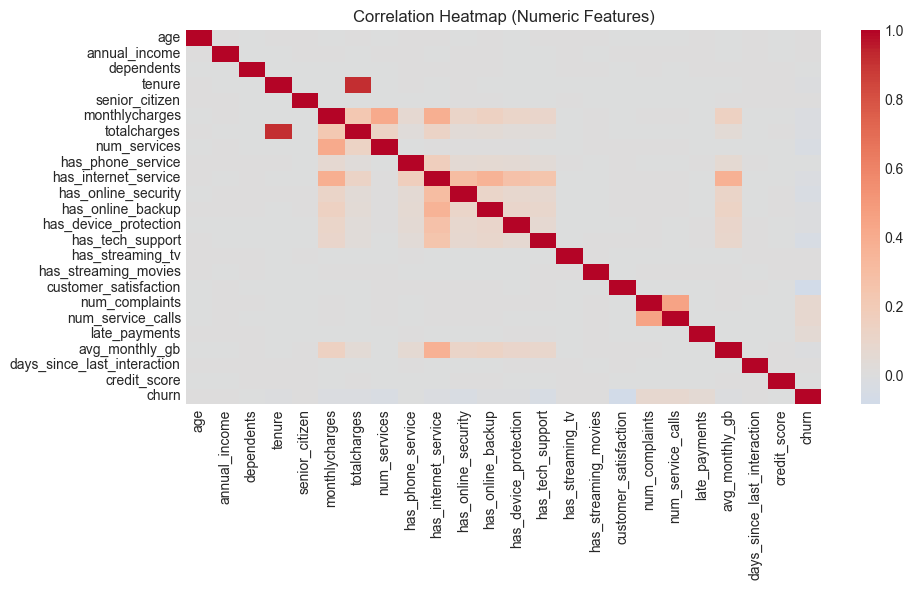

Top positive correlations with churn:


num_complaints         0.080
num_service_calls      0.077
late_payments          0.048
has_streaming_movies   0.002
has_streaming_tv       0.001
Name: churn, dtype: float64

Top negative correlations with churn:


totalcharges            -0.017
num_services            -0.033
has_online_security     -0.034
has_tech_support        -0.045
customer_satisfaction   -0.085
Name: churn, dtype: float64

In [34]:
# Correlation matrix for numeric features
numeric_cols = df.select_dtypes(include=["number"]).columns.tolist()
if "churn" in numeric_cols:
    numeric_cols.remove("churn")
    numeric_cols.append("churn")

corr_matrix = df[numeric_cols].corr(numeric_only=True)
display(corr_matrix.round(3))

plt.figure(figsize=(10, 6))
sns.heatmap(corr_matrix, cmap="coolwarm", center=0)
plt.title("Correlation Heatmap (Numeric Features)")
plt.tight_layout()
plt.show()

corr_with_churn = corr_matrix["churn"].drop("churn").sort_values(ascending=False)
print("Top positive correlations with churn:")
display(corr_with_churn.head(5))
print("Top negative correlations with churn:")
display(corr_with_churn.tail(5))

Correlation highlights which numeric features move with churn and can guide feature selection or sanity checks for multicollinearity. Strong negative correlations can indicate protective factors (e.g., longer tenure), while strong positive correlations indicate risk drivers.

## Grouping Data (Aggregation Analysis)

In [35]:
def churn_group_summary(data, group_col):
    if group_col not in data.columns:
        return None
    return (
        data.groupby(group_col)
        .agg(
            churn_rate=("churn", "mean"),
            customer_count=("churn", "size"),
            avg_monthly_charges=("monthlycharges", "mean"),
        )
        .sort_values("churn_rate", ascending=False)
    )

# Create tenure group for aggregation
if "tenure" in df.columns and "tenure_group" not in df.columns:
    df["tenure_group"] = pd.cut(
        df["tenure"],
        bins=[0, 12, 24, 36, 48, 60, np.inf],
        labels=["0-12", "13-24", "25-36", "37-48", "49-60", "61+"],
    )

for col in ["contract", "tenure_group", "payment_method"]:
    summary = churn_group_summary(df, col)
    if summary is not None:
        print(f"\n{col} summary")
        display(summary)


contract summary


,churn_rate,customer_count,avg_monthly_charges
contract,,,
month_to_month,0.265,19992,86.284
one_year,0.127,550468,86.497
two_year,0.057,429540,86.383



tenure_group summary


,churn_rate,customer_count,avg_monthly_charges
tenure_group,,,
0-12,0.103,418055,86.410
13-24,0.100,228860,86.520
25-36,0.098,139525,86.450
37-48,0.094,83532,86.534
61+,0.092,78815,86.250
49-60,0.092,51213,86.513



payment_method summary


,churn_rate,customer_count,avg_monthly_charges
payment_method,,,
electronic_check,0.099,250346,86.435
bank_transfer,0.099,249910,86.396
credit_card,0.099,349706,86.461
mailed_check,0.099,150038,86.498


These summaries show which customer segments churn more and how pricing differs by segment, guiding targeted retention actions.

## ANOVA (Numerical vs Categorical)

In [36]:
from scipy.stats import f_oneway

anova_features = ["tenure", "monthlycharges"]
for feature in anova_features:
    if feature in df.columns:
        group_0 = df.loc[df["churn"] == 0, feature].dropna()
        group_1 = df.loc[df["churn"] == 1, feature].dropna()
        f_stat, p_value = f_oneway(group_0, group_1)
        print(f"{feature}: F-stat={f_stat:.3f}, p-value={p_value:.6f}")

tenure: F-stat=161.537, p-value=0.000000
monthlycharges: F-stat=191.819, p-value=0.000000


ANOVA tests whether the mean of a numeric feature differs between churned vs retained customers. A low p-value suggests the feature provides useful signal for churn prediction.

## Correlation Analysis

,corr_with_churn
customer_satisfaction,-0.085
has_tech_support,-0.045
has_online_security,-0.034
num_services,-0.033
totalcharges,-0.017
has_internet_service,-0.015
monthlycharges,-0.014
tenure,-0.013
avg_monthly_gb,-0.006
has_online_backup,-0.005


,top_negative,top_positive
customer_satisfaction,-0.085,NaN
has_online_security,-0.034,NaN
has_streaming_movies,NaN,0.002
has_streaming_tv,NaN,0.001
has_tech_support,-0.045,NaN
late_payments,NaN,0.048
num_complaints,NaN,0.080
num_service_calls,NaN,0.077
num_services,-0.033,NaN
totalcharges,-0.017,NaN


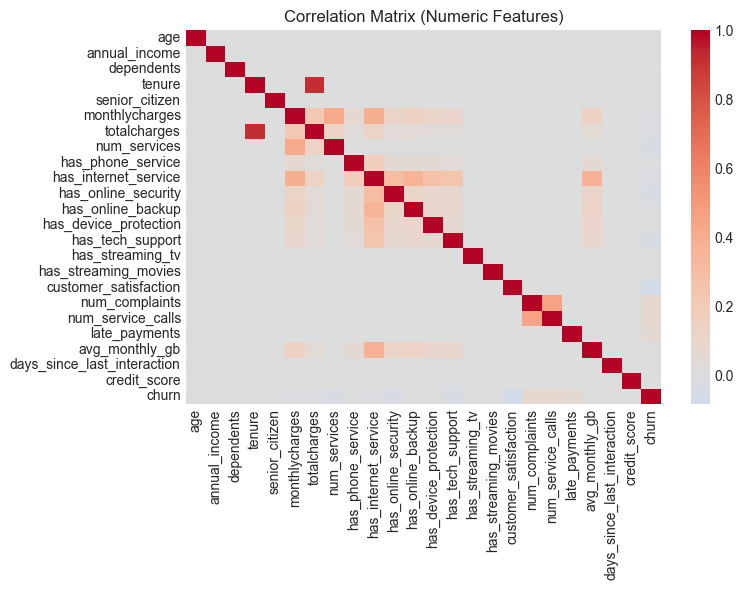

In [37]:
# Correlation table for numeric features and churn
num_df = df.select_dtypes(include=["number"]).copy()
corr = num_df.corr(numeric_only=True)

corr_target = corr["churn"].drop("churn").sort_values()
display(corr_target.to_frame("corr_with_churn"))

top_neg = corr_target.head(5)
top_pos = corr_target.tail(5)
display(pd.DataFrame({"top_negative": top_neg, "top_positive": top_pos}))

plt.figure(figsize=(8, 6))
sns.heatmap(corr, cmap="coolwarm", center=0)
plt.title("Correlation Matrix (Numeric Features)")
plt.tight_layout()
plt.show()

Correlation highlights linear relationships with churn and helps prioritize or remove redundant numeric features.

## Train–Test Split

### Define modeling columns & leakage exclusions

In [38]:
target = "churn"

id_cols = ["customer_id", "account_number"]
leakage_cols = [
    "churn_date",
    "cancellation_reason",
    "last_contact_result",
    "refund_amount",
    "agent_notes",
]
drop_cols = [c for c in id_cols + leakage_cols if c in df.columns]

df_model = df.drop(columns=drop_cols).copy()
assert target in df_model.columns, "Target column 'churn' not found"

feature_cols = [c for c in df_model.columns if c != target]
print(f"Dropped columns (id/leakage): {drop_cols}")
print(f"Modeling features: {len(feature_cols)}")

Dropped columns (id/leakage): ['customer_id']
Modeling features: 31


### Train–Test Split

In [39]:
X = df_model.drop(columns=[target])
y = df_model[target].astype(int)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
 )

print("Train size:", X_train.shape, "| Test size:", X_test.shape)
print("Train churn rate:", y_train.mean().round(3))
print("Test churn rate:", y_test.mean().round(3))

Train size: (800000, 31) | Test size: (200000, 31)
Train churn rate: 0.099
Test churn rate: 0.099


## Preprocessing Pipeline (Leakage-Free)

In [40]:
# Simple, leakage-safe feature engineering
def add_features(df, stats=None):
    df = df.copy()
    stats = stats or {}

    if "tenure" in df.columns:
        stats.setdefault("tenure_median", df["tenure"].median())
    if "monthlycharges" in df.columns:
        stats.setdefault("monthly_median", df["monthlycharges"].median())
        vals = df["monthlycharges"].dropna().values
        if "monthly_bins" not in stats and len(vals) > 0:
            stats["monthly_bins"] = np.histogram_bin_edges(vals, bins=4)

    # Ratio + log
    if {"totalcharges", "tenure"}.issubset(df.columns):
        df["charges_per_tenure"] = df["totalcharges"] / (df["tenure"] + 1)
    if "totalcharges" in df.columns:
        df["log_total_charges"] = np.log1p(df["totalcharges"])

    # Interaction
    if {"monthlycharges", "tenure"}.issubset(df.columns):
        df["high_charge_long_tenure"] = (
            (df["monthlycharges"] > stats.get("monthly_median", df["monthlycharges"].median()))
            & (df["tenure"] > stats.get("tenure_median", df["tenure"].median()))
        ).astype(int)

    # Service count
    service_cols = [c for c in df.columns if "service" in c or c.startswith("has_")]
    if service_cols:
        temp = df[service_cols].astype(str).apply(lambda s: s.str.lower())
        temp = temp.replace({"yes": 1, "no": 0, "true": 1, "false": 0}).fillna(0)
        df["total_services"] = temp.apply(pd.to_numeric, errors="coerce").fillna(0).sum(axis=1)

    # Binning
    if "tenure" in df.columns:
        df["tenure_group"] = pd.cut(
            df["tenure"],
            bins=[0, 12, 24, 36, 48, 60, np.inf],
            labels=["0-12", "13-24", "25-36", "37-48", "49-60", "61+"],
        )
    if "monthlycharges" in df.columns and "monthly_bins" in stats:
        df["monthly_charges_bin"] = pd.cut(
            df["monthlycharges"],
            bins=stats["monthly_bins"],
            labels=["low", "medium", "high", "very_high"],
            include_lowest=True,
        )

    return df, stats

def prepare_data(X_train, X_test, rare_thresh=0.01):
    # Feature engineering
    X_train, stats = add_features(X_train)
    X_test, _ = add_features(X_test, stats)

    # Identify types
    num_cols = X_train.select_dtypes(include=["number"]).columns.tolist()
    cat_cols = X_train.select_dtypes(include=["object", "category", "bool"]).columns.tolist()

    # Impute missing with train stats
    for col in num_cols:
        X_train[col] = X_train[col].fillna(X_train[col].median())
        X_test[col] = X_test[col].fillna(X_train[col].median())
    for col in cat_cols:
        mode = X_train[col].mode(dropna=True)
        fill = mode.iloc[0] if len(mode) else "Unknown"
        X_train[col] = X_train[col].fillna(fill)
        X_test[col] = X_test[col].fillna(fill)

    # Ensure categorical columns can accept "Other"
    for col in cat_cols:
        X_train[col] = X_train[col].astype(str)
        X_test[col] = X_test[col].astype(str)

    # Rare category grouping
    for col in cat_cols:
        freq = X_train[col].value_counts(normalize=True)
        keep = freq[freq >= rare_thresh].index
        X_train[col] = X_train[col].where(X_train[col].isin(keep), "Other")
        X_test[col] = X_test[col].where(X_test[col].isin(keep), "Other")

    # One-hot encoding
    X_train = pd.get_dummies(X_train, columns=cat_cols, drop_first=True)
    X_test = pd.get_dummies(X_test, columns=cat_cols, drop_first=True)
    X_train, X_test = X_train.align(X_test, join="left", axis=1, fill_value=0)

    # Scaling
    scaler = StandardScaler()
    X_train[num_cols] = scaler.fit_transform(X_train[num_cols])
    X_test[num_cols] = scaler.transform(X_test[num_cols])

    # Variance filter
    vt = VarianceThreshold(threshold=0.0001)
    X_train_v = vt.fit_transform(X_train)
    X_test_v = vt.transform(X_test)
    final_cols = X_train.columns[vt.get_support()]

    X_train_final = pd.DataFrame(X_train_v, columns=final_cols, index=X_train.index)
    X_test_final = pd.DataFrame(X_test_v, columns=final_cols, index=X_test.index)
    return X_train_final, X_test_final, final_cols, scaler, vt

### Simple preprocessing (train-fit, test-apply)

#### Feature engineering + encoding

In [41]:
# Drop datetime columns to avoid dtype promotion issues in preprocessing
datetime_cols = X_train.select_dtypes(include=["datetime64[ns]", "datetime64[ns, UTC]"]).columns
if len(datetime_cols) > 0:
	X_train = X_train.drop(columns=datetime_cols)
	X_test = X_test.drop(columns=datetime_cols)

# Prepare final training and test matrices
X_train_final, X_test_final, final_features, scaler, vt = prepare_data(X_train, X_test)

print(f"Train shape: {X_train_final.shape}")
print(f"Test shape: {X_test_final.shape}")
print(f"Final feature count: {len(final_features)}")

Train shape: (800000, 48)
Test shape: (200000, 48)
Final feature count: 48


### Feature space tracking

In [42]:
# Feature space summary
print(f"Features after preprocessing: {X_train_final.shape[1]}")

Features after preprocessing: 48


### Near-zero variance filter

#### Update Categorical Column List

In [43]:
# variance_selector defined above for feature tracking

### Optional class balancing (SMOTE)

In [44]:
# Optional: balance training data for models that need it
smote = SMOTE(random_state=42)
X_train_bal, y_train_bal = smote.fit_resample(X_train_final, y_train)
print("Balanced class distribution:", pd.Series(y_train_bal).value_counts().to_dict())

Balanced class distribution: {0: 720618, 1: 720618}


## Baseline Model + Business Cost Evaluation

In [45]:
# Business assumptions (adjust with stakeholders)
RETENTION_COST = 50   # cost of contacting/retention offer
CHURN_LOSS = 500      # lost revenue when a churner is missed

def business_cost(y_true, y_pred):
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    return fp * RETENTION_COST + fn * CHURN_LOSS

# Baseline: do nothing (predict no churn for all)
baseline_pred = np.zeros_like(y_test)
baseline_cost = business_cost(y_test, baseline_pred)
print(f"Baseline cost (do nothing): {baseline_cost:,.0f}")

def find_optimal_threshold(y_true, y_prob, thresholds=None):
    if thresholds is None:
        thresholds = np.linspace(0.01, 0.99, 99)
    costs = []
    for t in thresholds:
        y_pred = (y_prob >= t).astype(int)
        costs.append(business_cost(y_true, y_pred))
    best_idx = int(np.argmin(costs))
    return thresholds[best_idx], costs


Baseline cost (do nothing): 9,922,500


### Evaluation utilities (consistent metrics)

In [46]:
def evaluate_model(model, X_train, y_train, X_test, y_test, model_name, threshold=0.5):
    model.fit(X_train, y_train)
    y_prob = model.predict_proba(X_test)[:, 1]
    y_pred = (y_prob >= threshold).astype(int)

    metrics = {
        "Model": model_name,
        "Accuracy": accuracy_score(y_test, y_pred),
        "Precision": precision_score(y_test, y_pred, zero_division=0),
        "Recall": recall_score(y_test, y_pred, zero_division=0),
        "F1": f1_score(y_test, y_pred, zero_division=0),
        "ROC_AUC": roc_auc_score(y_test, y_prob),
        "Brier": brier_score_loss(y_test, y_prob),
        "Business_Cost": business_cost(y_test, y_pred),
        "Threshold": threshold,
    }

    print(f"\nModel: {model_name}")
    for k, v in metrics.items():
        if k not in {"Model"}:
            print(f"{k}: {v:.4f}" if isinstance(v, float) else f"{k}: {v}")

    # ROC Curve
    fpr, tpr, _ = roc_curve(y_test, y_prob)
    plt.figure()
    plt.plot(fpr, tpr, label=f"{model_name}")
    plt.plot([0, 1], [0, 1], linestyle="--")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title(f"ROC Curve - {model_name}")
    plt.legend()
    plt.show()

    # Confusion Matrix
    cm = confusion_matrix(y_test, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot()
    plt.title(f"Confusion Matrix - {model_name}")
    plt.show()

    return metrics, model

### Baseline model: Logistic Regression (interpretable, fast)

Optimal threshold (cost-based): 0.47


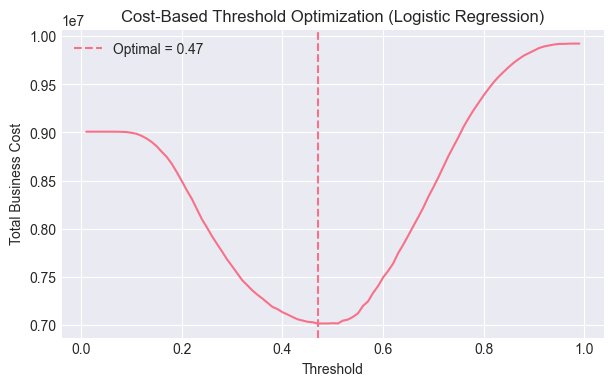


Model: Logistic Regression
Accuracy: 0.5775
Precision: 0.1484
Recall: 0.6876
F1: 0.2441
ROC_AUC: 0.6801
Brier: 0.2229
Business_Cost: 7015200
Threshold: 0.4700


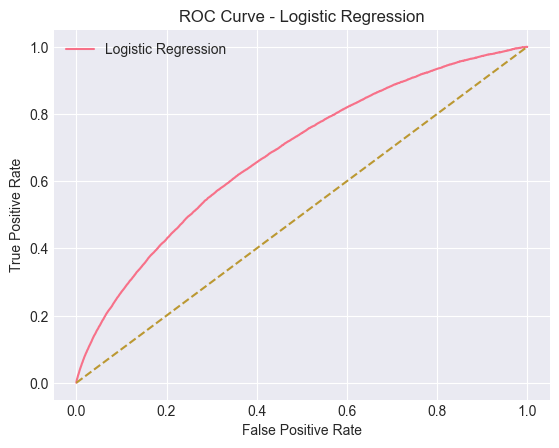

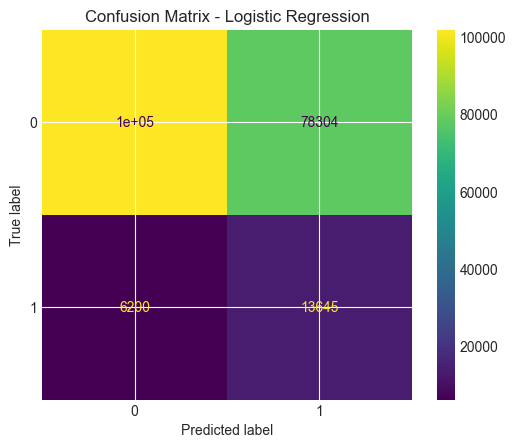

In [47]:
log_reg = LogisticRegression(max_iter=1000, n_jobs=-1, random_state=42)
log_reg.fit(X_train_bal, y_train_bal)
log_prob = log_reg.predict_proba(X_test_final)[:, 1]

opt_threshold, cost_curve = find_optimal_threshold(y_test, log_prob)
print(f"Optimal threshold (cost-based): {opt_threshold:.2f}")

plt.figure(figsize=(7,4))
thresholds = np.linspace(0.01, 0.99, 99)
plt.plot(thresholds, cost_curve)
plt.axvline(opt_threshold, linestyle="--", label=f"Optimal = {opt_threshold:.2f}")
plt.xlabel("Threshold")
plt.ylabel("Total Business Cost")
plt.title("Cost-Based Threshold Optimization (Logistic Regression)")
plt.legend()
plt.show()

log_metrics, log_model = evaluate_model(
    log_reg, X_train_bal, y_train_bal, X_test_final, y_test,
    "Logistic Regression", threshold=opt_threshold
 )

#### Decision Gate 1: Is the baseline good enough?
- Compare baseline cost to “do nothing” and ensure recall meets retention goals.
- If business cost savings are marginal or recall is too low, proceed to advanced models.

In [48]:
print(f"Baseline (do nothing) cost: {baseline_cost:,.0f}")
print(f"Logistic Regression cost: {log_metrics['Business_Cost']:,.0f}")
print(f"Cost reduction: {(baseline_cost - log_metrics['Business_Cost']):,.0f}")

Baseline (do nothing) cost: 9,922,500
Logistic Regression cost: 7,015,200
Cost reduction: 2,907,300


## Advanced Models

### Decision Tree (non-linear, interpretable)


Model: Decision Tree
Accuracy: 0.6441
Precision: 0.1397
Recall: 0.5014
F1: 0.2185
ROC_AUC: 0.6267
Brier: 0.1568
Business_Cost: 8011150
Threshold: 0.5000


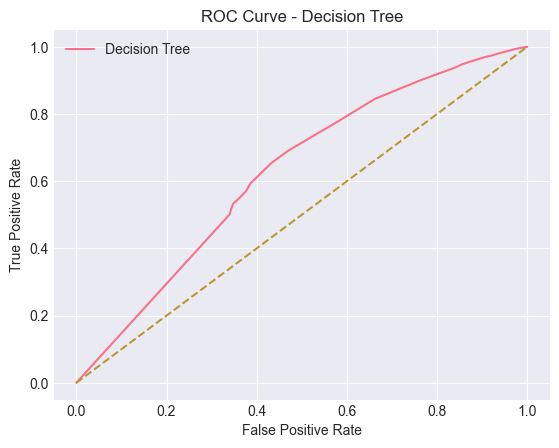

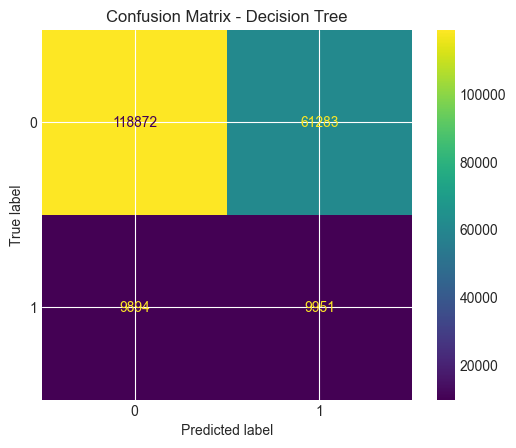

In [49]:
dt = DecisionTreeClassifier(max_depth=6, min_samples_split=100, random_state=42)
dt_metrics, dt_model = evaluate_model(
    dt, X_train_bal, y_train_bal, X_test_final, y_test, "Decision Tree"
 )

### Random Forest (robust default for churn)

- Handles interactions automatically
- Robust to noisy/irrelevant features
- Strong default for tabular churn prediction


Model: Random Forest
Accuracy: 0.6030
Precision: 0.1517
Recall: 0.6537
F1: 0.2463
ROC_AUC: 0.6774
Brier: 0.2230
Business_Cost: 7062100
Threshold: 0.5000


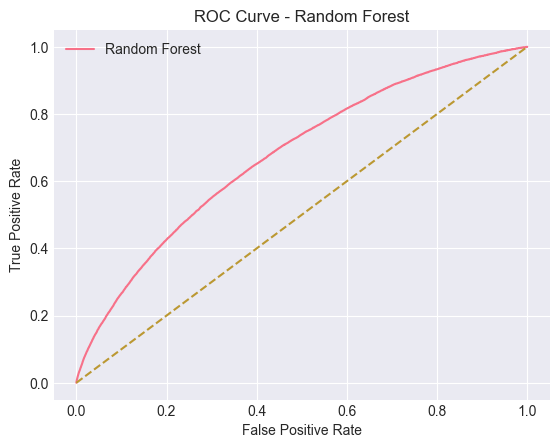

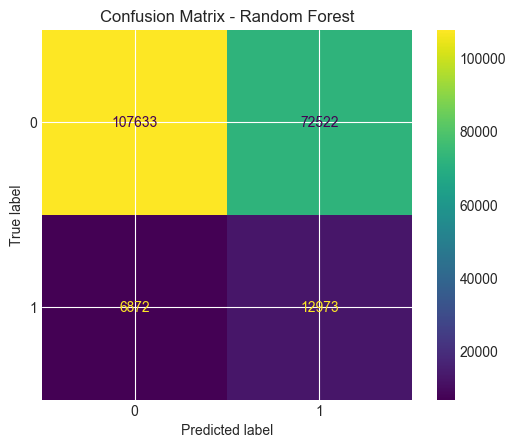

In [50]:
rf = RandomForestClassifier(
    n_estimators=200, max_depth=10, min_samples_split=100,
    class_weight="balanced", random_state=42, n_jobs=-1
 )
rf_metrics, rf_model = evaluate_model(
    rf, X_train_final, y_train, X_test_final, y_test, "Random Forest"
 )

### XGBoost (high performance, tuned later)


Model: XGBoost
Accuracy: 0.6352
Precision: 0.1597
Recall: 0.6278
F1: 0.2546
ROC_AUC: 0.6841
Brier: 0.2193
Business_Cost: 6972250
Threshold: 0.5000


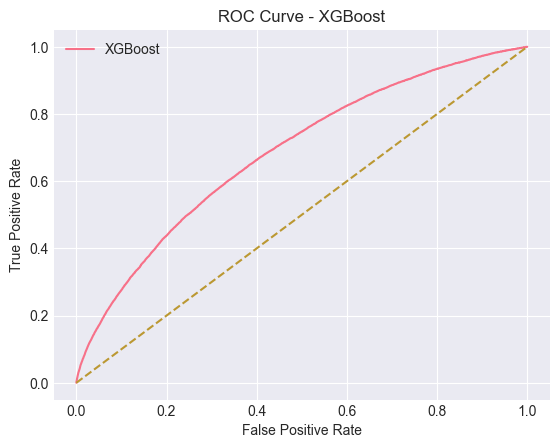

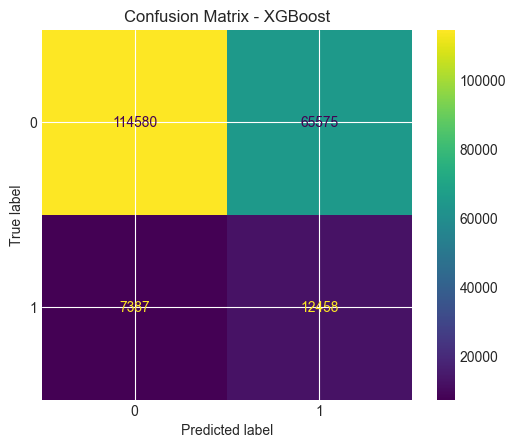

In [51]:
from xgboost import XGBClassifier

xgb = XGBClassifier(
    n_estimators=300, max_depth=6, learning_rate=0.05,
    subsample=0.8, colsample_bytree=0.8,
    objective="binary:logistic", eval_metric="auc",
    scale_pos_weight=(y_train == 0).sum() / (y_train == 1).sum(),
    random_state=42, n_jobs=-1
 )
xgb_metrics, xgb_model = evaluate_model(
    xgb, X_train_final, y_train, X_test_final, y_test, "XGBoost"
 )

### LightGBM (efficient gradient boosting)

[LightGBM] [Info] Number of positive: 79382, number of negative: 720618
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.078331 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2335
[LightGBM] [Info] Number of data points in the train set: 800000, number of used features: 48
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.000000

Model: LightGBM
Accuracy: 0.6385
Precision: 0.1608
Recall: 0.6266
F1: 0.2559
ROC_AUC: 0.6846
Brier: 0.2193
Business_Cost: 6949700
Threshold: 0.5000


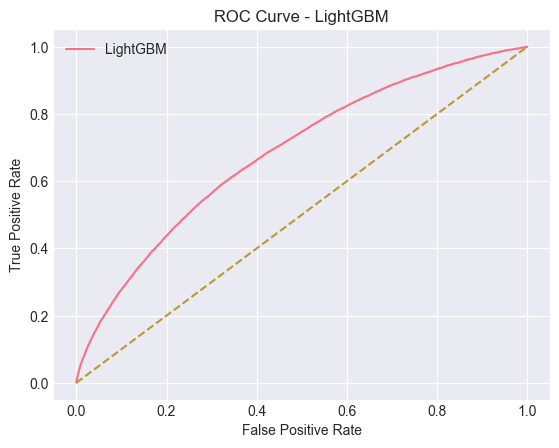

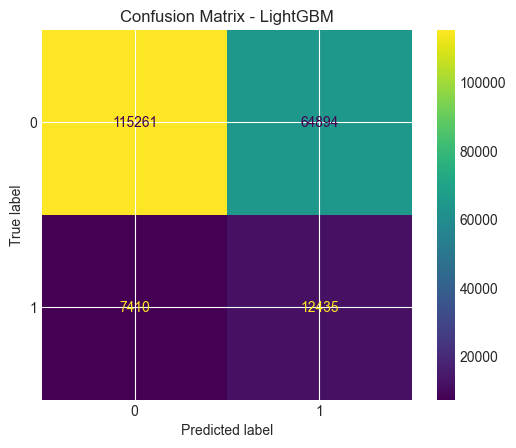

In [52]:
from lightgbm import LGBMClassifier

lgbm = LGBMClassifier(
    n_estimators=500, learning_rate=0.05, num_leaves=31,
    subsample=0.8, colsample_bytree=0.8,
    class_weight="balanced", random_state=42, n_jobs=-1
 )
lgbm_metrics, lgbm_model = evaluate_model(
    lgbm, X_train_final, y_train, X_test_final, y_test, "LightGBM"
 )

## Model Comparison

### Metrics table & plots

,Accuracy,Precision,Recall,F1,ROC_AUC,Brier,Business_Cost,Threshold
Model,,,,,,,,
LightGBM,0.638,0.161,0.627,0.256,0.685,0.219,6949700,0.500
XGBoost,0.635,0.160,0.628,0.255,0.684,0.219,6972250,0.500
Logistic Regression,0.577,0.148,0.688,0.244,0.680,0.223,7015200,0.470
Random Forest,0.603,0.152,0.654,0.246,0.677,0.223,7062100,0.500
Decision Tree,0.644,0.140,0.501,0.219,0.627,0.157,8011150,0.500


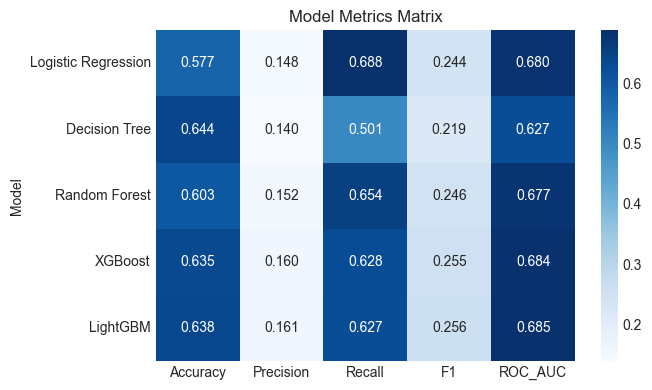

In [53]:
results_df = pd.DataFrame([
    log_metrics,
    dt_metrics,
    rf_metrics,
    xgb_metrics,
    lgbm_metrics,
]).set_index("Model")

display(results_df.sort_values("Business_Cost"))

plt.figure(figsize=(7,4))
sns.heatmap(results_df[["Accuracy","Precision","Recall","F1","ROC_AUC"]], annot=True, fmt=".3f", cmap="Blues")
plt.title("Model Metrics Matrix")
plt.tight_layout()
plt.show()

### Decision Gate 2: Cost-aware selection
Select the model with the lowest business cost while maintaining acceptable recall and stability.

Best model by business cost: LightGBM
Optimal threshold for LightGBM: 0.48


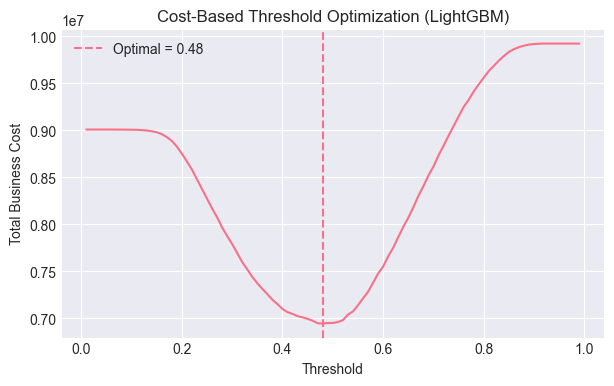

In [54]:
best_model_name = results_df["Business_Cost"].idxmin()
print("Best model by business cost:", best_model_name)

best_model_map = {
    "Logistic Regression": log_model,
    "Decision Tree": dt_model,
    "Random Forest": rf_model,
    "XGBoost": xgb_model,
    "LightGBM": lgbm_model,
}
best_model = best_model_map[best_model_name]

best_prob = best_model.predict_proba(X_test_final)[:, 1]
best_threshold, best_cost_curve = find_optimal_threshold(y_test, best_prob)
print(f"Optimal threshold for {best_model_name}: {best_threshold:.2f}")

plt.figure(figsize=(7,4))
thresholds = np.linspace(0.01, 0.99, 99)
plt.plot(thresholds, best_cost_curve)
plt.axvline(best_threshold, linestyle="--", label=f"Optimal = {best_threshold:.2f}")
plt.xlabel("Threshold")
plt.ylabel("Total Business Cost")
plt.title(f"Cost-Based Threshold Optimization ({best_model_name})")
plt.legend()
plt.show()

## Explainability (SHAP)

,feature,mean_abs_shap
0,contract_two_year,0.527
1,customer_satisfaction,0.213
2,has_tech_support,0.146
3,num_complaints,0.140
4,late_payments,0.117
5,num_service_calls,0.117
6,contract_one_year,0.115
7,has_online_security,0.106
8,num_services,0.105
9,monthlycharges,0.061


Global mean |SHAP|: 0.038027919545400905
Top-1 feature contribution: contract_two_year 0.5271836915636805


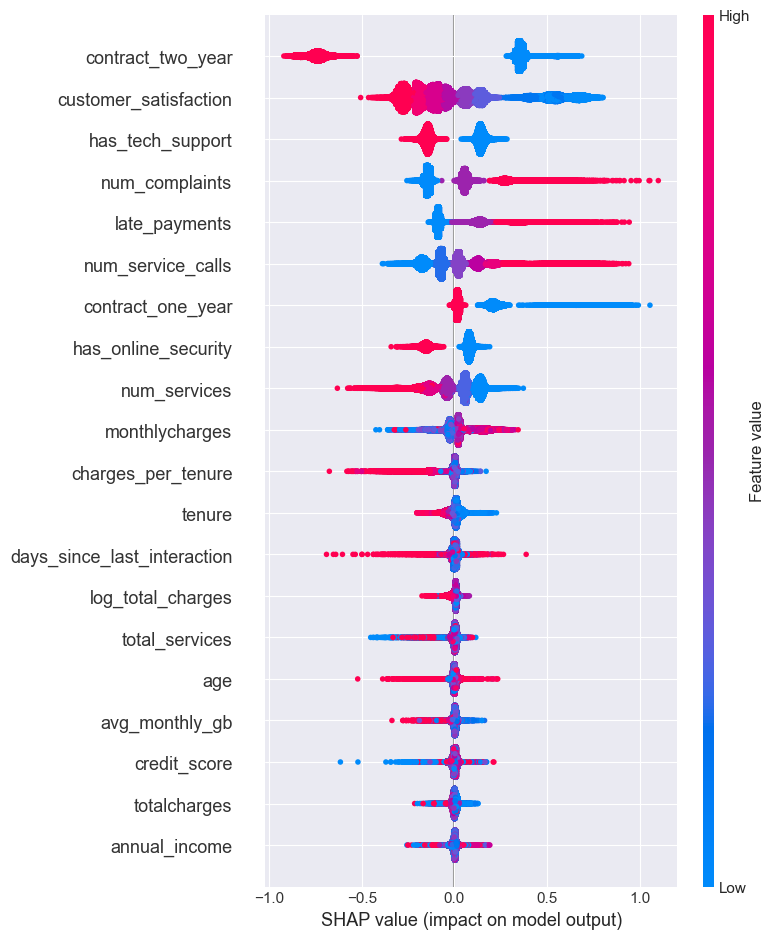

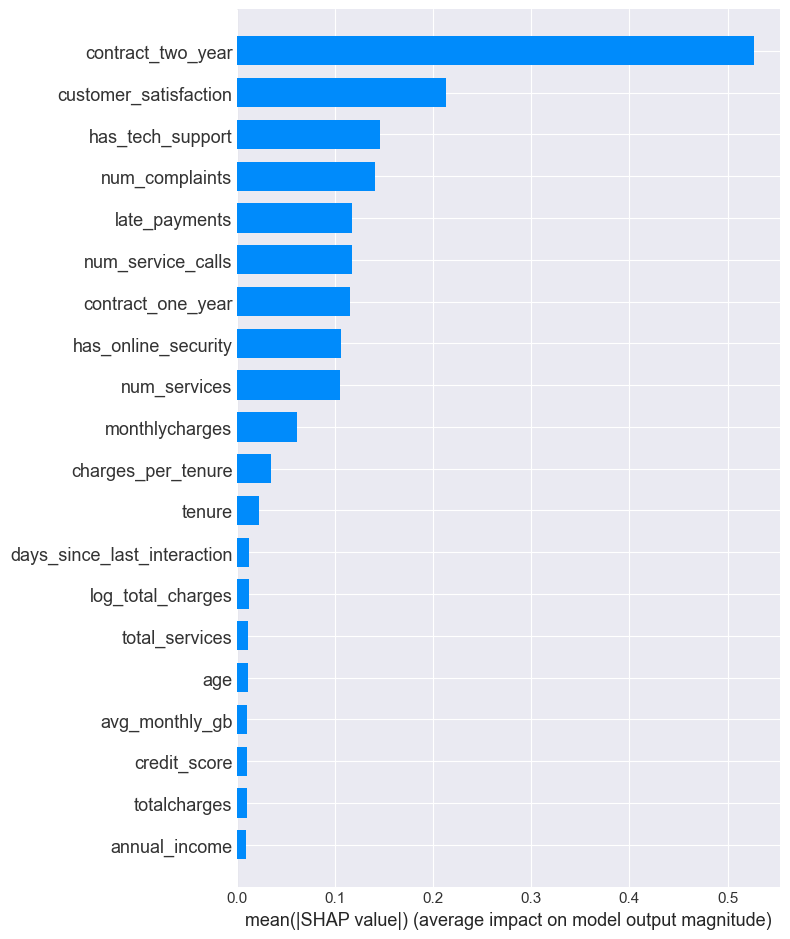

In [55]:
import shap

X_test_shap = X_test_final.copy()
feature_names = X_test_shap.columns
mdl = best_model

# Compute SHAP values
if hasattr(mdl, "feature_importances_") or mdl.__class__.__name__.lower().find("gb") >= 0:
    explainer = shap.TreeExplainer(mdl)
    shap_values = explainer.shap_values(X_test_shap)
else:
    explainer = shap.LinearExplainer(mdl, X_test_shap, feature_perturbation="interventional")
    shap_values = explainer.shap_values(X_test_shap)

# SHAP metrics (global importance)
shap_arr = shap_values[1] if isinstance(shap_values, list) and len(shap_values) > 1 else shap_values
mean_abs_shap = np.abs(shap_arr).mean(axis=0)
shap_metrics_df = (
    pd.DataFrame({"feature": feature_names, "mean_abs_shap": mean_abs_shap})
    .sort_values("mean_abs_shap", ascending=False)
    .reset_index(drop=True)
 )

display(shap_metrics_df.head(15))
print("Global mean |SHAP|:", float(mean_abs_shap.mean()))
print("Top-1 feature contribution:", shap_metrics_df.iloc[0]["feature"], float(shap_metrics_df.iloc[0]["mean_abs_shap"]))

# Plots
shap.summary_plot(shap_arr, X_test_shap, plot_type="dot")
shap.summary_plot(shap_arr, X_test_shap, plot_type="bar")

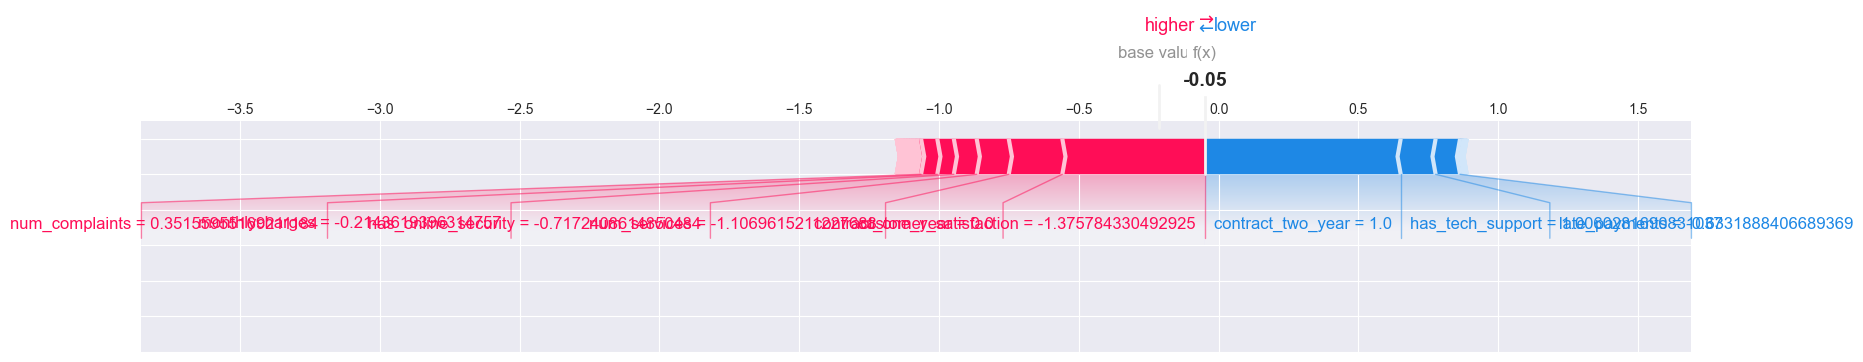

In [56]:

customer_index = 0  # any row index

shap.force_plot(
    explainer.expected_value,
    shap_values[customer_index],
    X_test_final.iloc[customer_index],
    matplotlib=True
)

## Final Decision & Business Recommendations

In [58]:
final_metrics = results_df.loc[best_model_name].to_dict()
print("Final model:", best_model_name)

print("Chosen threshold:", round(best_threshold, 2))
print("Business cost:", f"{final_metrics['Business_Cost']:,.0f}")
print("Recall:", round(final_metrics["Recall"], 3))
print("ROC AUC:", round(final_metrics["ROC_AUC"], 3))


Final model: LightGBM
Chosen threshold: 0.48
Business cost: 6,949,700
Recall: 0.627
ROC AUC: 0.685


In [59]:
import pickle

artifact = {
    "model": best_model,
    "scaler": scaler,
    "variance_threshold": vt,
    "final_features": list(final_features),
    "best_threshold": float(best_threshold),
    "feature_cols": feature_cols,
    "drop_cols": drop_cols,
}

with open("churn_model_artifact.pkl", "wb") as f:
    pickle.dump(artifact, f)

print("Saved model artifact to churn_model_artifact.pkl")

Saved model artifact to churn_model_artifact.pkl
